In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import copy

In [ ]:
# For GradCAM
from collections import OrderedDict

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Load datasets
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
val_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val)

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of batches per epoch (train): {len(train_loader)}")
print(f"Number of batches per epoch (val): {len(val_loader)}")

Number of training samples: 50000
Number of validation samples: 10000
Number of batches per epoch (train): 391
Number of batches per epoch (val): 79


In [ ]:
def get_vgg_model(model_name, num_classes=100, pretrained=False):
    if model_name == 'vgg11':
        model = models.vgg11_bn(pretrained=pretrained)
    elif model_name == 'vgg16':
        model = models.vgg16_bn(pretrained=pretrained)
    elif model_name == 'vgg19':
        model = models.vgg19_bn(pretrained=pretrained)
    else:
        raise ValueError(f"Unknown VGG model name: {model_name}")

    # Adapt the classifier for CIFAR-100 (input to classifier will be different for 32x32 images vs 224x224)
    # VGG with BatchNorm (e.g., vgg11_bn) uses Sequential(Linear, ReLU, Dropout, Linear, ReLU, Dropout, Linear)
    # The last Linear layer needs to be changed.
    num_ftrs = model.classifier[0].in_features # Get input features to the first linear layer

    # For CIFAR-100 32x32 images, after 5 MaxPool2d layers (stride 2 each),
    # the feature map size becomes 32 / (2^5) = 1.
    # So the output of features will be 512 * 1 * 1 = 512
    # The default VGG models from torchvision are designed for 224x224 ImageNet,
    # resulting in 512 * 7 * 7 features (for a 7x7 avgpool).
    # For CIFAR-100, with an AdaptiveAvgPool2d(output_size=(1,1)),
    # the features fed into the classifier will be 512.

    # Let's adjust for CIFAR-100 32x32, we assume an adaptive average pooling layer
    # will be used to reduce feature maps to 1x1.
    # The VGG_bn models usually have AdaptiveAvgPool2d at the end of features.
    # The classifier takes 512 features if AdaptiveAvgPool2d(1,1) is applied.
    # However, the torchvision VGG models are usually designed with a default input size,
    # and the classifier's first layer `in_features` reflects that.
    # For 32x32 CIFAR-100, the last conv layer outputs 512 channels.
    # After the last MaxPool2d(kernel_size=2, stride=2), a 32x32 image becomes 1x1.
    # So the classifier should expect 512 features.

    # If the default torchvision VGG classifier is used, it expects 25088 (512*7*7) features.
    # We need to replace the classifier to handle 512 features after avgpool(1,1).

    # Let's verify the actual input features if we use AdaptiveAvgPool2d(1,1)
    if 'bn' in model_name: # VGG_bn models
        model.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Ensure 1x1 output from avgpool
        model.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096), # Default VGG has 4096, but we can simplify
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    else: # VGG models without BN
        model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        model.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    # A simpler classifier might be:
    model.classifier = nn.Sequential(
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(512, num_classes),
    )


    print(f"{model_name.upper()} model initialized. Classifier adapted for {num_classes} classes. Input features to classifier: {model.classifier[0].in_features}")
    return model

# Example of how to get a VGG-11 model
# vgg11_example = get_vgg_model('vgg11', pretrained=False)
# print(vgg11_example)

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, model_name, scheduler=None, distillation_loss_fn=None, teacher_model=None, temperature=1.0, alpha=0.5):
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")

        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            student_outputs = model(inputs)

            if distillation_loss_fn:
                # Distillation loss involves teacher
                if teacher_model is None:
                    raise ValueError("Teacher model must be provided for distillation loss.")

                with torch.no_grad():
                    teacher_outputs = teacher_model(inputs)

                # Calculate hard loss (cross-entropy with true labels)
                hard_loss = criterion(student_outputs, labels)

                # Calculate distillation loss
                if distillation_loss_fn.__name__ == 'logit_matching_loss':
                    kd_loss = distillation_loss_fn(student_outputs, teacher_outputs, temperature)
                    loss = alpha * hard_loss + (1. - alpha) * kd_loss
                elif distillation_loss_fn.__name__ == 'decoupled_kd_loss':
                    kd_loss = distillation_loss_fn(student_outputs, teacher_outputs, labels, temperature)
                    loss = hard_loss + kd_loss # DKD often sums directly, not weighted by alpha
                elif distillation_loss_fn.__name__ == 'label_smoothing_loss':
                    # Label smoothing is applied directly in the criterion for hard labels
                    # So 'distillation_loss_fn' here means the custom criterion
                    loss = criterion(student_outputs, labels) # criterion is already LS
                else:
                    # Default if another KD method is integrated here
                    kd_loss = distillation_loss_fn(student_outputs, teacher_outputs, labels, temperature)
                    loss = alpha * hard_loss + (1. - alpha) * kd_loss # generic KD combo
            else:
                # Standard training (e.g., independent student)
                loss = criterion(student_outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_loader_tqdm.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_dataset)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, distillation_loss_fn, teacher_model, temperature, alpha)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'{model_name}.pth')
            print(f"Best model saved with accuracy: {best_acc:.4f}")

        if scheduler:
            scheduler.step()

    model.load_state_dict(best_model_wts)
    print("Training complete.")
    return model, history, best_acc

def evaluate_model(model, data_loader, criterion, distillation_loss_fn=None, teacher_model=None, temperature=1.0, alpha=0.5):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if distillation_loss_fn and distillation_loss_fn.__name__ != 'label_smoothing_loss':
                # For evaluation, we typically just care about the hard loss / classification accuracy
                # But to maintain consistency in reported 'Val Loss', we can compute the combined loss
                # However, for true evaluation, only the hard loss matters for accuracy comparison
                hard_loss = F.cross_entropy(outputs, labels)

                if teacher_model:
                    teacher_outputs = teacher_model(inputs)
                    if distillation_loss_fn.__name__ == 'logit_matching_loss':
                        kd_loss = distillation_loss_fn(outputs, teacher_outputs, temperature)
                        loss = alpha * hard_loss + (1. - alpha) * kd_loss
                    elif distillation_loss_fn.__name__ == 'decoupled_kd_loss':
                        kd_loss = distillation_loss_fn(outputs, teacher_outputs, labels, temperature)
                        loss = hard_loss + kd_loss
                    else: # Generic KD evaluation loss
                        kd_loss = distillation_loss_fn(outputs, teacher_outputs, labels, temperature)
                        loss = alpha * hard_loss + (1. - alpha) * kd_loss
                else: # Fallback if teacher not provided but distillation_loss_fn is
                     loss = hard_loss
            else:
                # Standard evaluation loss (CrossEntropy or Label Smoothing CE)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} Training History - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
#section 1

--- Cell 6: Training Independent Student (SI) - VGG-11 ---
VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Training VGG-11 Independent Student (SI)...
Starting training for 30 epochs...


Epoch 1/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 4.3142, Val Loss: 4.0604, Val Acc: 0.0488
Best model saved with accuracy: 0.0488


Epoch 2/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/30], Train Loss: 4.0459, Val Loss: 3.9715, Val Acc: 0.0682
Best model saved with accuracy: 0.0682


Epoch 3/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/30], Train Loss: 3.9377, Val Loss: 3.8369, Val Acc: 0.0722
Best model saved with accuracy: 0.0722


Epoch 4/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/30], Train Loss: 3.7931, Val Loss: 3.6345, Val Acc: 0.1050
Best model saved with accuracy: 0.1050


Epoch 5/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/30], Train Loss: 3.5938, Val Loss: 3.3784, Val Acc: 0.1314
Best model saved with accuracy: 0.1314


Epoch 6/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/30], Train Loss: 3.4088, Val Loss: 3.3312, Val Acc: 0.1497
Best model saved with accuracy: 0.1497


Epoch 7/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/30], Train Loss: 3.2522, Val Loss: 3.0826, Val Acc: 0.1918
Best model saved with accuracy: 0.1918


Epoch 8/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/30], Train Loss: 3.1020, Val Loss: 2.9378, Val Acc: 0.2311
Best model saved with accuracy: 0.2311


Epoch 9/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/30], Train Loss: 2.9806, Val Loss: 2.7241, Val Acc: 0.2631
Best model saved with accuracy: 0.2631


Epoch 10/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/30], Train Loss: 2.8631, Val Loss: 2.6493, Val Acc: 0.2876
Best model saved with accuracy: 0.2876


Epoch 11/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/30], Train Loss: 2.5674, Val Loss: 2.3342, Val Acc: 0.3616
Best model saved with accuracy: 0.3616


Epoch 12/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/30], Train Loss: 2.4801, Val Loss: 2.2860, Val Acc: 0.3687
Best model saved with accuracy: 0.3687


Epoch 13/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/30], Train Loss: 2.4206, Val Loss: 2.2304, Val Acc: 0.3862
Best model saved with accuracy: 0.3862


Epoch 14/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/30], Train Loss: 2.3660, Val Loss: 2.2073, Val Acc: 0.3910
Best model saved with accuracy: 0.3910


Epoch 15/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/30], Train Loss: 2.3285, Val Loss: 2.1614, Val Acc: 0.4037
Best model saved with accuracy: 0.4037


Epoch 16/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/30], Train Loss: 2.2957, Val Loss: 2.1442, Val Acc: 0.4094
Best model saved with accuracy: 0.4094


Epoch 17/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/30], Train Loss: 2.2434, Val Loss: 2.1064, Val Acc: 0.4219
Best model saved with accuracy: 0.4219


Epoch 18/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/30], Train Loss: 2.2072, Val Loss: 2.0942, Val Acc: 0.4276
Best model saved with accuracy: 0.4276


Epoch 19/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/30], Train Loss: 2.1571, Val Loss: 2.0547, Val Acc: 0.4404
Best model saved with accuracy: 0.4404


Epoch 20/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/30], Train Loss: 2.1269, Val Loss: 2.0294, Val Acc: 0.4425
Best model saved with accuracy: 0.4425


Epoch 21/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [21/30], Train Loss: 2.0574, Val Loss: 1.9930, Val Acc: 0.4506
Best model saved with accuracy: 0.4506


Epoch 22/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [22/30], Train Loss: 2.0430, Val Loss: 1.9854, Val Acc: 0.4520
Best model saved with accuracy: 0.4520


Epoch 23/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [23/30], Train Loss: 2.0327, Val Loss: 1.9799, Val Acc: 0.4576
Best model saved with accuracy: 0.4576


Epoch 24/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [24/30], Train Loss: 2.0214, Val Loss: 1.9761, Val Acc: 0.4588
Best model saved with accuracy: 0.4588


Epoch 25/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [25/30], Train Loss: 2.0100, Val Loss: 1.9736, Val Acc: 0.4577


Epoch 26/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [26/30], Train Loss: 2.0089, Val Loss: 1.9734, Val Acc: 0.4607
Best model saved with accuracy: 0.4607


Epoch 27/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [27/30], Train Loss: 2.0056, Val Loss: 1.9640, Val Acc: 0.4621
Best model saved with accuracy: 0.4621


Epoch 28/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [28/30], Train Loss: 1.9967, Val Loss: 1.9569, Val Acc: 0.4660
Best model saved with accuracy: 0.4660


Epoch 29/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [29/30], Train Loss: 1.9833, Val Loss: 1.9647, Val Acc: 0.4631


Epoch 30/30 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [30/30], Train Loss: 1.9788, Val Loss: 1.9581, Val Acc: 0.4636
Training complete.
Independent Student (SI) - Final Validation Accuracy: 0.4660
Independent Student (SI) - Final Validation Loss: 1.9581


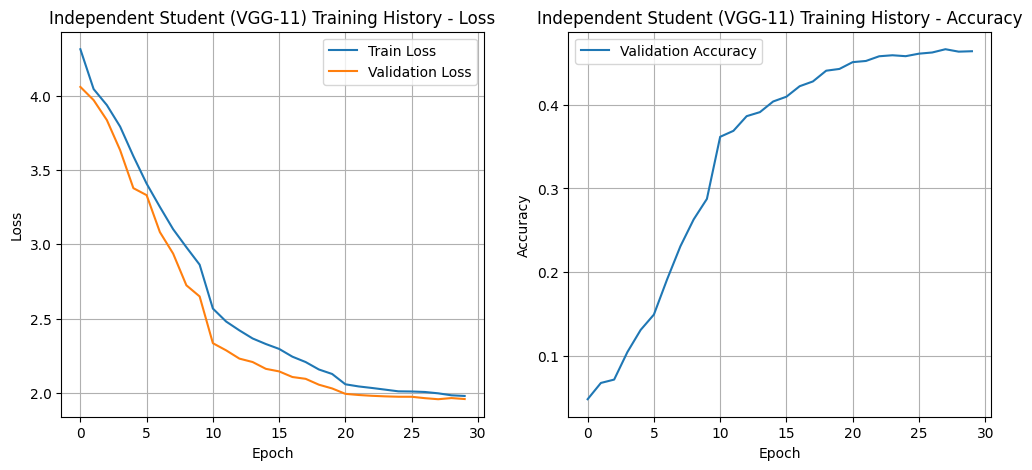

In [ ]:
print("--- Cell 6: Training Independent Student (SI) - VGG-11 ---")

student_si = get_vgg_model('vgg11', pretrained=False).to(device)
criterion_si = nn.CrossEntropyLoss()
optimizer_si = optim.Adam(student_si.parameters(), lr=0.001, weight_decay=5e-4)
scheduler_si = optim.lr_scheduler.StepLR(optimizer_si, step_size=10, gamma=0.1)
num_epochs_si = 30

print("Training VGG-11 Independent Student (SI)...")
student_si, history_si, final_acc_si = train_model(
    student_si, train_loader, val_loader, optimizer_si, criterion_si,
    num_epochs_si, 'Independent Student (SI)' , scheduler=scheduler_si
)

print(f"Independent Student (SI) - Final Validation Accuracy: {final_acc_si:.4f}")
print(f"Independent Student (SI) - Final Validation Loss: {history_si['val_loss'][-1]:.4f}")

plot_training_history(history_si, 'Independent Student (VGG-11)')

--- Cell 7: Loading/Setting up Teacher (T) - VGG-16 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 234MB/s] 


VGG16 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Fine-tuning ImageNet-pretrained VGG-16 Teacher on CIFAR-100...
Starting training for 10 epochs...


Epoch 1/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 3.9615, Val Loss: 2.8039, Val Acc: 0.3005
Best model saved with accuracy: 0.3005


Epoch 2/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 2.4735, Val Loss: 1.8042, Val Acc: 0.4911
Best model saved with accuracy: 0.4911


Epoch 3/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 1.8380, Val Loss: 1.4983, Val Acc: 0.5848
Best model saved with accuracy: 0.5848


Epoch 4/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 1.4593, Val Loss: 1.3421, Val Acc: 0.6249
Best model saved with accuracy: 0.6249


Epoch 5/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 1.2838, Val Loss: 1.2734, Val Acc: 0.6489
Best model saved with accuracy: 0.6489


Epoch 6/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 1.1511, Val Loss: 1.2408, Val Acc: 0.6555
Best model saved with accuracy: 0.6555


Epoch 7/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 1.0097, Val Loss: 1.1912, Val Acc: 0.6690
Best model saved with accuracy: 0.6690


Epoch 8/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.9416, Val Loss: 1.1888, Val Acc: 0.6727
Best model saved with accuracy: 0.6727


Epoch 9/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.8818, Val Loss: 1.1786, Val Acc: 0.6760
Best model saved with accuracy: 0.6760


Epoch 10/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.8178, Val Loss: 1.1672, Val Acc: 0.6869
Best model saved with accuracy: 0.6869
Training complete.
Teacher (T) - VGG-16 Final Validation Accuracy (after fine-tuning): 0.6869
Teacher (T) - VGG-16 Final Validation Loss (after fine-tuning): 1.1672


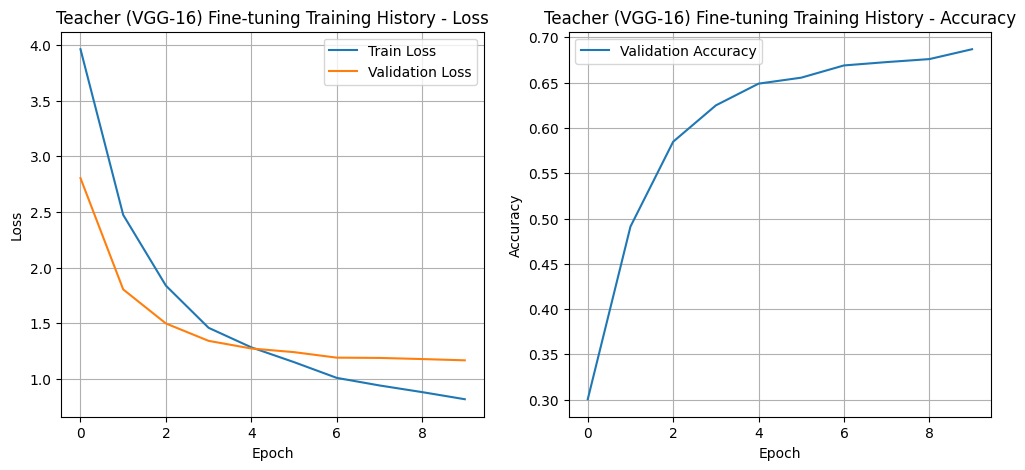

Teacher (T) VGG-16 model saved to 'teacher_t_vgg16_finetuned.pth'
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2,

In [ ]:
print("--- Cell 7: Loading/Setting up Teacher (T) - VGG-16 ---")

# Load pre-trained VGG-16 (on ImageNet)
teacher_t = get_vgg_model('vgg16', pretrained=True).to(device)
teacher_t.eval() # Set to eval mode for evaluation, but will train later

# Fine-tune the teacher on CIFAR-100
# Freeze features and train classifier initially, or unfreeze all if full fine-tuning.
# For simplicity, we'll train the whole model, but with a smaller LR and fewer epochs.
# The `get_vgg_model` function already adapted the classifier for 100 classes.

criterion_t = nn.CrossEntropyLoss()
optimizer_t = optim.Adam(teacher_t.parameters(), lr=0.0001, weight_decay=5e-4) # Smaller LR for fine-tuning
scheduler_t = optim.lr_scheduler.StepLR(optimizer_t, step_size=3, gamma=0.5)
num_epochs_t = 10 # Fewer epochs for fine-tuning

print("Fine-tuning ImageNet-pretrained VGG-16 Teacher on CIFAR-100...")
teacher_t, history_t, final_acc_t = train_model(
    teacher_t, train_loader, val_loader, optimizer_t, criterion_t,
    num_epochs_t, 'Teacher (VGG-16) fine-tuning', scheduler=scheduler_t
)
# Ensure the teacher is in evaluation mode after training
teacher_t.eval()

print(f"Teacher (T) - VGG-16 Final Validation Accuracy (after fine-tuning): {final_acc_t:.4f}")
print(f"Teacher (T) - VGG-16 Final Validation Loss (after fine-tuning): {history_t['val_loss'][-1]:.4f}")

plot_training_history(history_t, 'Teacher (VGG-16) Fine-tuning')
torch.save(teacher_t.state_dict(), 'teacher_t_vgg16_finetuned.pth')
print("Teacher (T) VGG-16 model saved to 'teacher_t_vgg16_finetuned.pth'")
print(teacher_t) # Print model architecture

In [ ]:
#section 2 -

In [ ]:
print("--- Cell 8: Defining Distillation Loss Functions ---")

# Logit Matching Loss (Kullback-Leibler Divergence)
# KLDivLoss expects log-probabilities for input and probabilities for target.
def logit_matching_loss(student_logits, teacher_logits, temperature):
    # Apply temperature
    soft_student_logits = student_logits / temperature
    soft_teacher_logits = teacher_logits / temperature

    # Compute soft targets (probabilities) from teacher logits
    p_teacher = F.softmax(soft_teacher_logits, dim=1)

    # Compute log-probabilities from student logits
    log_p_student = F.log_softmax(soft_student_logits, dim=1)

    # KLDivLoss requires input to be log-probabilities and target to be probabilities
    # reduction='batchmean' divides by batch size * number of elements (100 classes) by default,
    # but when multiplied by temperature**2, it effectively performs batchmean over a sum of KLs.
    # The original paper suggests multiplying by T^2 if batchmean is effectively sum of KLs.
    # PyTorch's KLDivLoss with reduction='batchmean' performs mean over batch.
    # So, we multiply by T^2 for consistency with the paper's formulation when using reduction='batchmean'.
    kd_loss = F.kl_div(log_p_student, p_teacher, reduction='batchmean') * (temperature ** 2)
    return kd_loss

# Label Smoothing Loss
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1, num_classes=100):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.num_classes = num_classes

    def forward(self, pred, target):
        log_softmax_pred = F.log_softmax(pred, dim=1)

        # Create smoothed target distribution
        # One-hot encoding of target
        one_hot = torch.zeros_like(log_softmax_pred).scatter_(1, target.unsqueeze(1), 1)
        # Apply smoothing
        smoothed_target = (1 - self.smoothing) * one_hot + self.smoothing / self.num_classes

        # Compute KL divergence
        return torch.sum(-smoothed_target * log_softmax_pred, dim=1).mean()

# Decoupled Knowledge Distillation Loss (DKD)
# Based on DKD paper (https://arxiv.org/pdf/2203.08679)
# def decoupled_kd_loss(student_logits, teacher_logits, labels, temperature):
#     gt_mask = F.one_hot(labels, num_classes=student_logits.shape[1]).bool()

    # Target class distillation (TCD)
    # Match student's logit for the ground truth class to teacher's logit
    # for the ground truth class, relative to other logits.

    # S_t_i_gt = F.log_softmax(student_logits / T, dim=1)[gt_mask]
    # T_t_i_gt = F.softmax(teacher_logits / T, dim=1)[gt_mask]
    # tcd_loss = -(T_t_i_gt * S_t_i_gt).mean() # This is a simplified view.

    # Correct TCD from paper: KLD(softmax(teacher_logits/T) || softmax(student_logits/T)) for target class.
    # This is more complex than simple matching. Let's use the explicit KLD over the *target* distribution.

    # For TCD, we take only the target class logit/probability and compare
    # TCD loss: KL(p_t(c_gt) || p_s(c_gt)) where p_t is teacher, p_s is student
    # Note: KLD is often calculated over full distributions,
    # but DKD simplifies it by focusing on the ground truth probabilities.

    # The paper's TCD loss involves ground-truth class probabilities,
    # and a special form of cross-entropy to make student's GT prob match teacher's.
    # This is more like a weighted cross-entropy for the GT class.

    # Re-implementing TCD and NCD according to the DKD paper details:
    # 1. Softmax over all classes for TCD (target class distillation)
    # The ground truth class probabilities are directly used.

    # pred_teacher_prob = F.softmax(teacher_logits / temperature, dim=1)
    # pred_student_prob = F.softmax(student_logits / temperature, dim=1)

    # # Target-class Distillation (TCD)
    # # Focus on the probability of the ground truth class

    # # Get ground-truth class probabilities for teacher and student
    # pred_teacher_gt = torch.masked_select(pred_teacher_prob, gt_mask)
    # pred_student_gt = torch.masked_select(pred_student_prob, gt_mask)

    # # TCD is Cross-entropy between student's GT log-prob and teacher's GT prob.
    # # Note: The original paper's loss formulation involves some specific normalizations.
    # # A common simplification for TCD is to use BCE or a similar loss on the GT probabilities.

    # # This part of DKD is often slightly ambiguous in implementation details.
    # # A robust way is to make the student's GT logit match the teacher's GT logit value.
    # # Or, make the student's GT probability match the teacher's GT probability.

    # # Let's use the formulation from RepDistiller (HobbitLong's repo), common for DKD:
    # # Non-target-class Distillation (NCD) for other classes
    # # KLDiv over non-target classes.
    # # This requires masks for non-target classes.
    # non_gt_mask = ~gt_mask

    # # Calculate probabilities for non-ground truth classes
    # pred_teacher_ng = torch.masked_select(pred_teacher_prob, non_gt_mask).reshape(student_logits.shape[0], -1)
    # pred_student_ng = torch.masked_select(pred_student_prob, non_gt_mask).reshape(student_logits.shape[0], -1)

    # log_pred_student_ng = F.log_softmax(student_logits / temperature, dim=1)[non_gt_mask].reshape(student_logits.shape[0], -1)

    # # DKD often uses a different form of NCD, where the non-target logits are normalized.
    # # NCD = KL(P_t_ng || P_s_ng) where P_ng are normalized probabilities for non-gt classes.

    # # From a standard DKD implementation:
    # # NCD: KL divergence of non-ground truth probabilities
    # # Normalized non-target probabilities
    # norm_pred_teacher_ng = pred_teacher_ng / pred_teacher_ng.sum(dim=1, keepdim=True)
    # norm_log_pred_student_ng = F.log_softmax(student_logits[:, non_gt_mask.reshape(student_logits.shape[0], -1).any(dim=0)] / temperature, dim=1)

    # ncd_loss = F.kl_div(norm_log_pred_student_ng, norm_pred_teacher_ng, reduction='batchmean') * (temperature ** 2)

    # # TCD: Binary Cross Entropy on ground truth probabilities
    # tcd_loss = F.binary_cross_entropy(pred_student_gt, pred_teacher_gt, reduction='mean') # Mean over batch

    # # Combined loss
    # # The original paper uses different weighting factors beta and gamma.
    # # For a general implementation, we might just sum them or use default weights.
    # # Let's use a simpler sum for now. The paper suggests alpha=1, beta=1 for DKD.
    # # DKD does not typically combine with CE like LM does with alpha.
    # # The paper's total loss is: (1 - alpha) * L_CE + beta * L_TCD + gamma * L_NCD
    # # where L_CE is the standard cross-entropy, alpha is the CE weight.
    # # For simplicity, if we provide the hard_loss separately, DKD loss is just TCD + NCD.
    # return tcd_loss + ncd_loss

print("Distillation loss functions defined.")

--- Cell 8: Defining Distillation Loss Functions ---
Distillation loss functions defined.


--- Cell 9: Training Student with Basic Logit Matching (LM-SD) ---
VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Training VGG-11 Student with Logit Matching (LM-SD)...
Starting training for 50 epochs...


Epoch 1/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 5.7059, Val Loss: 5.2377, Val Acc: 0.0587
Best model saved with accuracy: 0.0587


Epoch 2/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 5.2630, Val Loss: 4.9609, Val Acc: 0.0728
Best model saved with accuracy: 0.0728


Epoch 3/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 4.9527, Val Loss: 4.4970, Val Acc: 0.1227
Best model saved with accuracy: 0.1227


Epoch 4/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 4.6404, Val Loss: 4.1845, Val Acc: 0.1474
Best model saved with accuracy: 0.1474


Epoch 5/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 4.3433, Val Loss: 3.9395, Val Acc: 0.1790
Best model saved with accuracy: 0.1790


Epoch 6/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 4.0992, Val Loss: 3.7545, Val Acc: 0.2200
Best model saved with accuracy: 0.2200


Epoch 7/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 3.8584, Val Loss: 3.4310, Val Acc: 0.2564
Best model saved with accuracy: 0.2564


Epoch 8/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 3.6245, Val Loss: 3.1848, Val Acc: 0.2927
Best model saved with accuracy: 0.2927


Epoch 9/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 3.4477, Val Loss: 3.0120, Val Acc: 0.3252
Best model saved with accuracy: 0.3252


Epoch 10/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 3.2679, Val Loss: 2.9488, Val Acc: 0.3355
Best model saved with accuracy: 0.3355


Epoch 11/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 3.1191, Val Loss: 2.7315, Val Acc: 0.3713
Best model saved with accuracy: 0.3713


Epoch 12/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 2.9596, Val Loss: 2.6445, Val Acc: 0.3897
Best model saved with accuracy: 0.3897


Epoch 13/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 2.8553, Val Loss: 2.5870, Val Acc: 0.4088
Best model saved with accuracy: 0.4088


Epoch 14/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 2.7337, Val Loss: 2.5449, Val Acc: 0.4155
Best model saved with accuracy: 0.4155


Epoch 15/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 2.6330, Val Loss: 2.3670, Val Acc: 0.4432
Best model saved with accuracy: 0.4432


Epoch 16/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 2.2600, Val Loss: 1.9065, Val Acc: 0.5138
Best model saved with accuracy: 0.5138


Epoch 17/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 2.1262, Val Loss: 1.8503, Val Acc: 0.5272
Best model saved with accuracy: 0.5272


Epoch 18/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 2.0568, Val Loss: 1.8280, Val Acc: 0.5305
Best model saved with accuracy: 0.5305


Epoch 19/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 2.0139, Val Loss: 1.8013, Val Acc: 0.5397
Best model saved with accuracy: 0.5397


Epoch 20/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 1.9709, Val Loss: 1.7652, Val Acc: 0.5432
Best model saved with accuracy: 0.5432


Epoch 21/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 1.9324, Val Loss: 1.7450, Val Acc: 0.5477
Best model saved with accuracy: 0.5477


Epoch 22/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 1.9008, Val Loss: 1.7384, Val Acc: 0.5517
Best model saved with accuracy: 0.5517


Epoch 23/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 1.8613, Val Loss: 1.7159, Val Acc: 0.5559
Best model saved with accuracy: 0.5559


Epoch 24/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 1.8240, Val Loss: 1.7060, Val Acc: 0.5610
Best model saved with accuracy: 0.5610


Epoch 25/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 1.7798, Val Loss: 1.6928, Val Acc: 0.5623
Best model saved with accuracy: 0.5623


Epoch 26/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 1.7638, Val Loss: 1.6587, Val Acc: 0.5701
Best model saved with accuracy: 0.5701


Epoch 27/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 1.7298, Val Loss: 1.6625, Val Acc: 0.5699


Epoch 28/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 1.6964, Val Loss: 1.6309, Val Acc: 0.5689


Epoch 29/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 1.6601, Val Loss: 1.6241, Val Acc: 0.5725
Best model saved with accuracy: 0.5725


Epoch 30/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 1.6389, Val Loss: 1.6319, Val Acc: 0.5761
Best model saved with accuracy: 0.5761


Epoch 31/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 1.5676, Val Loss: 1.5920, Val Acc: 0.5811
Best model saved with accuracy: 0.5811


Epoch 32/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 1.5554, Val Loss: 1.5846, Val Acc: 0.5830
Best model saved with accuracy: 0.5830


Epoch 33/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 1.5423, Val Loss: 1.5830, Val Acc: 0.5827


Epoch 34/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 1.5415, Val Loss: 1.5770, Val Acc: 0.5846
Best model saved with accuracy: 0.5846


Epoch 35/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 1.5270, Val Loss: 1.5719, Val Acc: 0.5838


Epoch 36/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 1.5269, Val Loss: 1.5739, Val Acc: 0.5838


Epoch 37/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 1.5220, Val Loss: 1.5740, Val Acc: 0.5839


Epoch 38/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 1.5221, Val Loss: 1.5642, Val Acc: 0.5846


Epoch 39/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 1.5132, Val Loss: 1.5687, Val Acc: 0.5849
Best model saved with accuracy: 0.5849


Epoch 40/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 1.5131, Val Loss: 1.5684, Val Acc: 0.5836


Epoch 41/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 1.4983, Val Loss: 1.5681, Val Acc: 0.5855
Best model saved with accuracy: 0.5855


Epoch 42/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 1.5017, Val Loss: 1.5686, Val Acc: 0.5847


Epoch 43/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 1.4958, Val Loss: 1.5613, Val Acc: 0.5854


Epoch 44/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 1.4860, Val Loss: 1.5559, Val Acc: 0.5866
Best model saved with accuracy: 0.5866


Epoch 45/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 1.4852, Val Loss: 1.5568, Val Acc: 0.5865


Epoch 46/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 1.4839, Val Loss: 1.5539, Val Acc: 0.5866


Epoch 47/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 1.4838, Val Loss: 1.5529, Val Acc: 0.5880
Best model saved with accuracy: 0.5880


Epoch 48/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 1.4788, Val Loss: 1.5576, Val Acc: 0.5866


Epoch 49/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 1.4817, Val Loss: 1.5578, Val Acc: 0.5849


Epoch 50/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 1.4729, Val Loss: 1.5559, Val Acc: 0.5887
Best model saved with accuracy: 0.5887
Training complete.
Logit Matching Student (LM-SD) - Final Validation Accuracy: 0.5887
Logit Matching Student (LM-SD) - Final Validation Loss: 1.5559


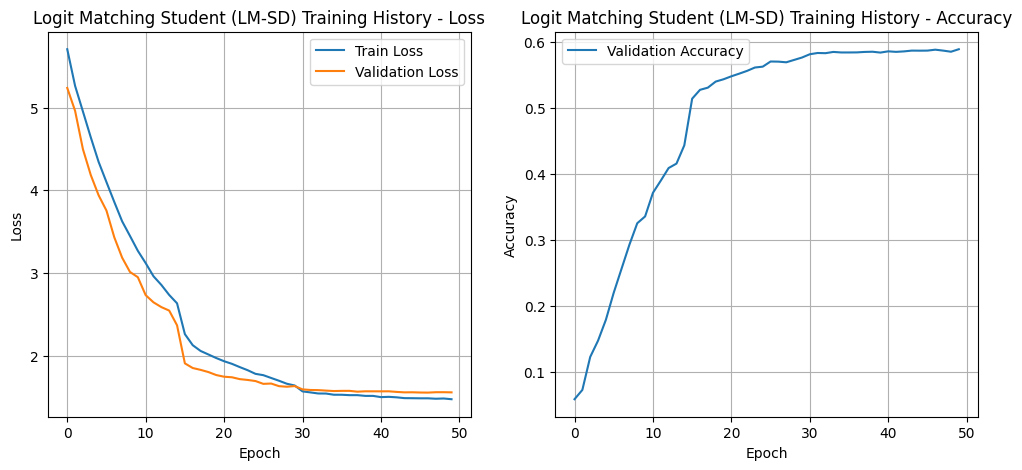

In [ ]:
print("--- Cell 9: Training Student with Basic Logit Matching (LM-SD) ---")

student_lm_sd = get_vgg_model('vgg11', pretrained=False).to(device)
criterion_lm_sd = nn.CrossEntropyLoss() # For the hard loss part
optimizer_lm_sd = optim.Adam(student_lm_sd.parameters(), lr=0.001, weight_decay=5e-4)
scheduler_lm_sd = optim.lr_scheduler.StepLR(optimizer_lm_sd, step_size=15, gamma=0.1)
num_epochs_lm_sd = 50

# Knowledge Distillation parameters
temperature = 4.0 # Common temperature value
alpha_lm = 0.7 # Weight for hard loss vs KD loss (0.7 means 70% hard, 30% KD)

print("Training VGG-11 Student with Logit Matching (LM-SD)...")
student_lm_sd, history_lm_sd, final_acc_lm_sd = train_model(
    student_lm_sd, train_loader, val_loader, optimizer_lm_sd, criterion_lm_sd,
    num_epochs_lm_sd, 'Logit Matching Student (LM-SD)', scheduler=scheduler_lm_sd,
    distillation_loss_fn=logit_matching_loss, teacher_model=teacher_t,
    temperature=temperature, alpha=alpha_lm
)

print(f"Logit Matching Student (LM-SD) - Final Validation Accuracy: {final_acc_lm_sd:.4f}")
print(f"Logit Matching Student (LM-SD) - Final Validation Loss: {history_lm_sd['val_loss'][-1]:.4f}")

plot_training_history(history_lm_sd, 'Logit Matching Student (LM-SD)')
torch.save(student_lm_sd.state_dict(), 'student_lm_sd_vgg11.pth')

--- Cell 10: Training Student with Label Smoothing Regularization (LS-SD) ---
VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Training VGG-11 Student with Label Smoothing (LS-SD)...
Starting training for 50 epochs...


Epoch 1/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 4.3877, Val Loss: 4.2543, Val Acc: 0.0398
Best model saved with accuracy: 0.0398


Epoch 2/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 4.1867, Val Loss: 4.0533, Val Acc: 0.0673
Best model saved with accuracy: 0.0673


Epoch 3/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 4.0569, Val Loss: 4.0803, Val Acc: 0.0703
Best model saved with accuracy: 0.0703


Epoch 4/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 3.9314, Val Loss: 3.7587, Val Acc: 0.1121
Best model saved with accuracy: 0.1121


Epoch 5/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 3.7949, Val Loss: 3.6752, Val Acc: 0.1315
Best model saved with accuracy: 0.1315


Epoch 6/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 3.6632, Val Loss: 3.5268, Val Acc: 0.1701
Best model saved with accuracy: 0.1701


Epoch 7/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 3.5347, Val Loss: 3.4995, Val Acc: 0.1881
Best model saved with accuracy: 0.1881


Epoch 8/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 3.4139, Val Loss: 3.2546, Val Acc: 0.2382
Best model saved with accuracy: 0.2382


Epoch 9/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 3.2987, Val Loss: 3.2488, Val Acc: 0.2493
Best model saved with accuracy: 0.2493


Epoch 10/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 3.2069, Val Loss: 3.1082, Val Acc: 0.2797
Best model saved with accuracy: 0.2797


Epoch 11/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 3.1137, Val Loss: 2.9199, Val Acc: 0.3302
Best model saved with accuracy: 0.3302


Epoch 12/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 3.0374, Val Loss: 2.9106, Val Acc: 0.3359
Best model saved with accuracy: 0.3359


Epoch 13/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 2.9649, Val Loss: 2.8967, Val Acc: 0.3451
Best model saved with accuracy: 0.3451


Epoch 14/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 2.9216, Val Loss: 2.7885, Val Acc: 0.3765
Best model saved with accuracy: 0.3765


Epoch 15/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 2.8504, Val Loss: 2.6801, Val Acc: 0.3977
Best model saved with accuracy: 0.3977


Epoch 16/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 2.6363, Val Loss: 2.4708, Val Acc: 0.4642
Best model saved with accuracy: 0.4642


Epoch 17/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 2.5599, Val Loss: 2.4478, Val Acc: 0.4652
Best model saved with accuracy: 0.4652


Epoch 18/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 2.5309, Val Loss: 2.4210, Val Acc: 0.4784
Best model saved with accuracy: 0.4784


Epoch 19/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 2.5069, Val Loss: 2.4088, Val Acc: 0.4785
Best model saved with accuracy: 0.4785


Epoch 20/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 2.4723, Val Loss: 2.3914, Val Acc: 0.4843
Best model saved with accuracy: 0.4843


Epoch 21/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 2.4508, Val Loss: 2.3679, Val Acc: 0.4915
Best model saved with accuracy: 0.4915


Epoch 22/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 2.4269, Val Loss: 2.3668, Val Acc: 0.4927
Best model saved with accuracy: 0.4927


Epoch 23/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 2.4025, Val Loss: 2.3572, Val Acc: 0.4966
Best model saved with accuracy: 0.4966


Epoch 24/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 2.3826, Val Loss: 2.3409, Val Acc: 0.4983
Best model saved with accuracy: 0.4983


Epoch 25/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 2.3551, Val Loss: 2.3225, Val Acc: 0.5059
Best model saved with accuracy: 0.5059


Epoch 26/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 2.3456, Val Loss: 2.3092, Val Acc: 0.5108
Best model saved with accuracy: 0.5108


Epoch 27/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 2.3218, Val Loss: 2.2927, Val Acc: 0.5178
Best model saved with accuracy: 0.5178


Epoch 28/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 2.3002, Val Loss: 2.2987, Val Acc: 0.5116


Epoch 29/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 2.2821, Val Loss: 2.2861, Val Acc: 0.5177


Epoch 30/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 2.2579, Val Loss: 2.2735, Val Acc: 0.5260
Best model saved with accuracy: 0.5260


Epoch 31/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 2.2163, Val Loss: 2.2554, Val Acc: 0.5303
Best model saved with accuracy: 0.5303


Epoch 32/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 2.2049, Val Loss: 2.2522, Val Acc: 0.5324
Best model saved with accuracy: 0.5324


Epoch 33/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 2.1980, Val Loss: 2.2517, Val Acc: 0.5316


Epoch 34/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 2.1965, Val Loss: 2.2468, Val Acc: 0.5327
Best model saved with accuracy: 0.5327


Epoch 35/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 2.1904, Val Loss: 2.2450, Val Acc: 0.5321


Epoch 36/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 2.1893, Val Loss: 2.2420, Val Acc: 0.5334
Best model saved with accuracy: 0.5334


Epoch 37/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 2.1853, Val Loss: 2.2431, Val Acc: 0.5360
Best model saved with accuracy: 0.5360


Epoch 38/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 2.1799, Val Loss: 2.2429, Val Acc: 0.5369
Best model saved with accuracy: 0.5369


Epoch 39/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 2.1708, Val Loss: 2.2401, Val Acc: 0.5373
Best model saved with accuracy: 0.5373


Epoch 40/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 2.1659, Val Loss: 2.2417, Val Acc: 0.5338


Epoch 41/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 2.1664, Val Loss: 2.2418, Val Acc: 0.5358


Epoch 42/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 2.1660, Val Loss: 2.2377, Val Acc: 0.5362


Epoch 43/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 2.1634, Val Loss: 2.2371, Val Acc: 0.5376
Best model saved with accuracy: 0.5376


Epoch 44/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 2.1571, Val Loss: 2.2356, Val Acc: 0.5360


Epoch 45/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 2.1572, Val Loss: 2.2372, Val Acc: 0.5389
Best model saved with accuracy: 0.5389


Epoch 46/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 2.1498, Val Loss: 2.2347, Val Acc: 0.5384


Epoch 47/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 2.1546, Val Loss: 2.2343, Val Acc: 0.5399
Best model saved with accuracy: 0.5399


Epoch 48/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 2.1590, Val Loss: 2.2355, Val Acc: 0.5368


Epoch 49/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 2.1515, Val Loss: 2.2366, Val Acc: 0.5386


Epoch 50/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 2.1486, Val Loss: 2.2344, Val Acc: 0.5386
Training complete.
Label Smoothing Student (LS-SD) - Final Validation Accuracy: 0.5399
Label Smoothing Student (LS-SD) - Final Validation Loss: 2.2344


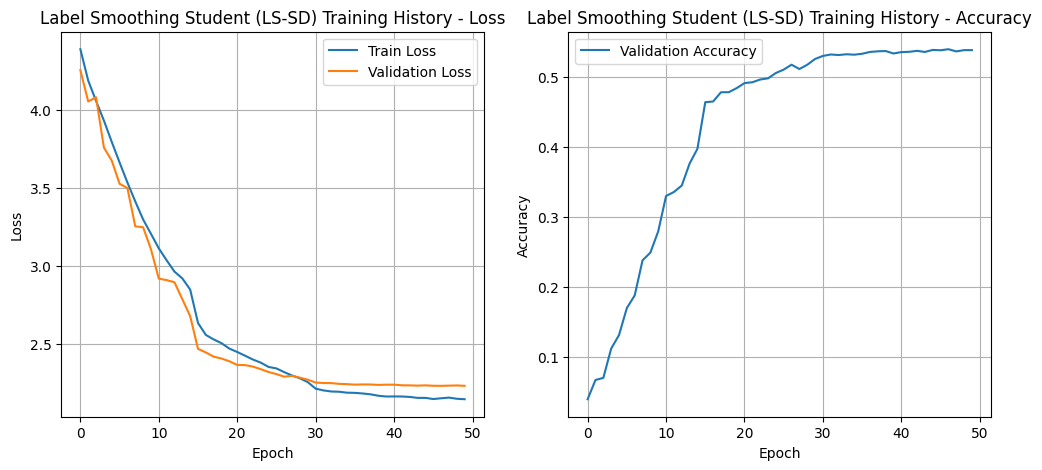

In [ ]:
print("--- Cell 10: Training Student with Label Smoothing Regularization (LS-SD) ---")

student_ls_sd = get_vgg_model('vgg11', pretrained=False).to(device)
# Use the custom LabelSmoothingCrossEntropy as the criterion
criterion_ls_sd = LabelSmoothingCrossEntropy(smoothing=0.1, num_classes=100).to(device)
optimizer_ls_sd = optim.Adam(student_ls_sd.parameters(), lr=0.001, weight_decay=5e-4)
scheduler_ls_sd = optim.lr_scheduler.StepLR(optimizer_ls_sd, step_size=15, gamma=0.1)
num_epochs_ls_sd = 50

print("Training VGG-11 Student with Label Smoothing (LS-SD)...")
student_ls_sd, history_ls_sd, final_acc_ls_sd = train_model(
    student_ls_sd, train_loader, val_loader, optimizer_ls_sd, criterion_ls_sd, # Keep optimizer and criterion swapped as per previous fix
    num_epochs_ls_sd, 'Label Smoothing Student (LS-SD)', scheduler=scheduler_ls_sd
    # REMOVE: distillation_loss_fn=label_smoothing_loss # This is causing the NameError
    # The 'criterion_ls_sd' already handles label smoothing
)

print(f"Label Smoothing Student (LS-SD) - Final Validation Accuracy: {final_acc_ls_sd:.4f}")
print(f"Label Smoothing Student (LS-SD) - Final Validation Loss: {history_ls_sd['val_loss'][-1]:.4f}")

plot_training_history(history_ls_sd, 'Label Smoothing Student (LS-SD)')
torch.save(student_ls_sd.state_dict(), 'student_ls_sd_vgg11.pth')

In [ ]:
def decoupled_kd_loss(student_logits, teacher_logits, labels, temperature):
    # Ensure logits are on the correct device
    student_logits = student_logits.to(labels.device)
    teacher_logits = teacher_logits.to(labels.device)

    gt_mask = F.one_hot(labels, num_classes=student_logits.shape[1]).bool()
    non_gt_mask = ~gt_mask

    # --- Target-class Distillation (TCD) ---
    # According to the DKD paper and common implementations (e.g., RepDistiller),
    # TCD is often implemented as a BCE-like loss on the ground-truth probabilities.

    # Apply temperature
    soft_teacher_logits = teacher_logits / temperature
    soft_student_logits = student_logits / temperature

    # Get probabilities
    pred_teacher_prob = F.softmax(soft_teacher_logits, dim=1)
    pred_student_prob = F.softmax(soft_student_logits, dim=1)

    # Ground truth probabilities
    pred_teacher_gt = torch.masked_select(pred_teacher_prob, gt_mask)
    pred_student_gt = torch.masked_select(pred_student_prob, gt_mask)

    # TCD: Binary Cross Entropy on ground truth probabilities
    # Adding a small epsilon to pred_student_gt to avoid log(0) if it's used directly
    # However, F.binary_cross_entropy already handles this robustness internally.
    tcd_loss = F.binary_cross_entropy(pred_student_gt, pred_teacher_gt, reduction='mean')


    # --- Non-target-class Distillation (NCD) ---
    # This is where your error was. We need to normalize *within* the non-ground truth classes.

    # Extract non-ground truth logits for teacher and student
    # For each sample, we need to select the non_gt_mask classes.
    # This requires a loop or careful tensor manipulation.

    # A more robust way: use advanced indexing with a loop (less efficient but clear)
    # or a tensor operation that handles the varying sizes.

    # Let's use a method often seen in DKD implementations, which involves
    # masking and then re-normalizing.

    # 1. Get non-ground truth probabilities from teacher and student
    #    This can be done by setting GT probabilities to 0 and then re-normalizing,
    #    or by explicitly extracting and normalizing.

    # For teacher non-gt probabilities:
    # Set ground truth probabilities to 0, then re-normalize the remaining
    # This implicitly creates the P_t_ng distribution
    pred_teacher_ng = pred_teacher_prob.clone()
    pred_teacher_ng[gt_mask] = 0.0 # Set GT class prob to 0
    norm_pred_teacher_ng = pred_teacher_ng / pred_teacher_ng.sum(dim=1, keepdim=True)
    # Handle potential NaNs if a row sums to 0 after masking (e.g., if batch size is 1 and all are GT)
    norm_pred_teacher_ng = torch.nan_to_num(norm_pred_teacher_ng, nan=0.0)

    # For student non-gt log-probabilities:
    # Similar approach, but with log_softmax
    log_pred_student_ng = F.log_softmax(soft_student_logits, dim=1)
    log_pred_student_ng_masked = log_pred_student_ng.clone()
    log_pred_student_ng_masked[gt_mask] = -float('inf') # Set GT class log-prob to -inf for correct log_softmax

    # Re-normalize log_softmax over non-ground truth classes.
    # We can do this by taking softmax and then log, or by explicitly adjusting.
    # A cleaner way for KLDiv is to make the input 'log-probabilities' over the non-gt set
    # and the target 'probabilities' over the non-gt set.

    # Let's derive the student's non-gt log-probabilities by taking softmax over all,
    # zeroing out GT, and then re-normalizing and taking log.
    student_ng_prob = pred_student_prob.clone()
    student_ng_prob[gt_mask] = 0.0
    student_ng_prob = student_ng_prob / student_ng_prob.sum(dim=1, keepdim=True)
    student_ng_prob = torch.nan_to_num(student_ng_prob, nan=0.0) # Handle potential NaNs
    norm_log_pred_student_ng = torch.log(student_ng_prob + 1e-10) # Add epsilon for log(0)

    # NCD: KL divergence of non-ground truth probabilities
    # PyTorch's KLDivLoss expects log-probabilities for the input and probabilities for the target.
    ncd_loss = F.kl_div(norm_log_pred_student_ng, norm_pred_teacher_ng, reduction='batchmean') * (temperature ** 2)

    # Combined loss
    # DKD typically uses (1-alpha) * L_CE + beta * L_TCD + gamma * L_NCD
    # If `hard_loss` is handled separately in `train_model`, then `decoupled_kd_loss`
    # should just return TCD + NCD.
    return tcd_loss + ncd_loss

--- Cell 11: Training Student with Decoupled Knowledge Distillation (DKD-SD) ---
VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Training VGG-11 Student with Decoupled Knowledge Distillation (DKD-SD)...
Starting training for 50 epochs...


Epoch 1/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 9.3579, Val Loss: 8.4187, Val Acc: 0.0731
Best model saved with accuracy: 0.0731


Epoch 2/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 8.3480, Val Loss: 7.8002, Val Acc: 0.1093
Best model saved with accuracy: 0.1093


Epoch 3/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 7.7434, Val Loss: 7.1341, Val Acc: 0.1400
Best model saved with accuracy: 0.1400


Epoch 4/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 7.2393, Val Loss: 6.6572, Val Acc: 0.1686
Best model saved with accuracy: 0.1686


Epoch 5/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 6.8379, Val Loss: 6.1679, Val Acc: 0.2159
Best model saved with accuracy: 0.2159


Epoch 6/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 6.4503, Val Loss: 6.1156, Val Acc: 0.2401
Best model saved with accuracy: 0.2401


Epoch 7/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 6.1425, Val Loss: 5.8430, Val Acc: 0.2582
Best model saved with accuracy: 0.2582


Epoch 8/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 5.7960, Val Loss: 5.4891, Val Acc: 0.2961
Best model saved with accuracy: 0.2961


Epoch 9/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 5.5209, Val Loss: 4.9087, Val Acc: 0.3507
Best model saved with accuracy: 0.3507


Epoch 10/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 5.2893, Val Loss: 4.8390, Val Acc: 0.3730
Best model saved with accuracy: 0.3730


Epoch 11/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 5.0717, Val Loss: 4.5184, Val Acc: 0.4093
Best model saved with accuracy: 0.4093


Epoch 12/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 4.8754, Val Loss: 4.2960, Val Acc: 0.4250
Best model saved with accuracy: 0.4250


Epoch 13/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 4.7007, Val Loss: 4.2203, Val Acc: 0.4380
Best model saved with accuracy: 0.4380


Epoch 14/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 4.5601, Val Loss: 4.2386, Val Acc: 0.4450
Best model saved with accuracy: 0.4450


Epoch 15/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 4.4345, Val Loss: 4.0225, Val Acc: 0.4687
Best model saved with accuracy: 0.4687


Epoch 16/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 3.8366, Val Loss: 3.3496, Val Acc: 0.5304
Best model saved with accuracy: 0.5304


Epoch 17/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 3.6421, Val Loss: 3.2645, Val Acc: 0.5412
Best model saved with accuracy: 0.5412


Epoch 18/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 3.5572, Val Loss: 3.2039, Val Acc: 0.5505
Best model saved with accuracy: 0.5505


Epoch 19/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 3.4924, Val Loss: 3.1734, Val Acc: 0.5539
Best model saved with accuracy: 0.5539


Epoch 20/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 3.4035, Val Loss: 3.1418, Val Acc: 0.5581
Best model saved with accuracy: 0.5581


Epoch 21/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 3.3519, Val Loss: 3.0995, Val Acc: 0.5680
Best model saved with accuracy: 0.5680


Epoch 22/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 3.3029, Val Loss: 3.0736, Val Acc: 0.5679


Epoch 23/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 3.2434, Val Loss: 3.0552, Val Acc: 0.5738
Best model saved with accuracy: 0.5738


Epoch 24/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 3.1973, Val Loss: 3.0197, Val Acc: 0.5746
Best model saved with accuracy: 0.5746


Epoch 25/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 3.1543, Val Loss: 2.9862, Val Acc: 0.5826
Best model saved with accuracy: 0.5826


Epoch 26/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 3.0988, Val Loss: 2.9817, Val Acc: 0.5856
Best model saved with accuracy: 0.5856


Epoch 27/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 3.0433, Val Loss: 2.9496, Val Acc: 0.5874
Best model saved with accuracy: 0.5874


Epoch 28/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 3.0164, Val Loss: 2.9470, Val Acc: 0.5909
Best model saved with accuracy: 0.5909


Epoch 29/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 2.9642, Val Loss: 2.9230, Val Acc: 0.5932
Best model saved with accuracy: 0.5932


Epoch 30/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 2.9160, Val Loss: 2.9164, Val Acc: 0.5915


Epoch 31/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 2.8364, Val Loss: 2.8619, Val Acc: 0.5997
Best model saved with accuracy: 0.5997


Epoch 32/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 2.8109, Val Loss: 2.8588, Val Acc: 0.6019
Best model saved with accuracy: 0.6019


Epoch 33/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 2.8045, Val Loss: 2.8490, Val Acc: 0.6032
Best model saved with accuracy: 0.6032


Epoch 34/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 2.7796, Val Loss: 2.8498, Val Acc: 0.6013


Epoch 35/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 2.7777, Val Loss: 2.8381, Val Acc: 0.6037
Best model saved with accuracy: 0.6037


Epoch 36/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 2.7805, Val Loss: 2.8376, Val Acc: 0.6057
Best model saved with accuracy: 0.6057


Epoch 37/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 2.7586, Val Loss: 2.8391, Val Acc: 0.6053


Epoch 38/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 2.7462, Val Loss: 2.8301, Val Acc: 0.6030


Epoch 39/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 2.7438, Val Loss: 2.8350, Val Acc: 0.6038


Epoch 40/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 2.7326, Val Loss: 2.8337, Val Acc: 0.6038


Epoch 41/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 2.7192, Val Loss: 2.8321, Val Acc: 0.6042


Epoch 42/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 2.7226, Val Loss: 2.8246, Val Acc: 0.6053


Epoch 43/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 2.7176, Val Loss: 2.8216, Val Acc: 0.6076
Best model saved with accuracy: 0.6076


Epoch 44/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 2.7135, Val Loss: 2.8202, Val Acc: 0.6054


Epoch 45/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 2.7178, Val Loss: 2.8189, Val Acc: 0.6065


Epoch 46/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 2.6838, Val Loss: 2.8173, Val Acc: 0.6080
Best model saved with accuracy: 0.6080


Epoch 47/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 2.7013, Val Loss: 2.8204, Val Acc: 0.6060


Epoch 48/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 2.6721, Val Loss: 2.8140, Val Acc: 0.6079


Epoch 49/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 2.6877, Val Loss: 2.8125, Val Acc: 0.6078


Epoch 50/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 2.6988, Val Loss: 2.8137, Val Acc: 0.6073
Training complete.
Decoupled KD Student (DKD-SD) - Final Validation Accuracy: 0.6080
Decoupled KD Student (DKD-SD) - Final Validation Loss: 2.8137


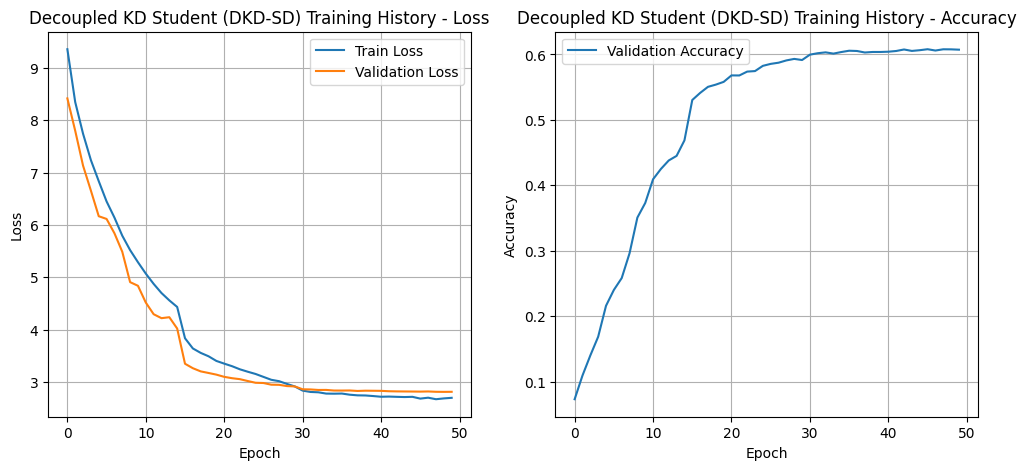

In [ ]:
# print("--- Cell 11: Training Student with Decoupled Knowledge Distillation (DKD-SD) ---")

# student_dkd_sd = get_vgg_model('vgg11', pretrained=False).to(device)
# criterion_dkd_sd = nn.CrossEntropyLoss() # For the hard loss part (L_CE in DKD paper)
# optimizer_dkd_sd = optim.Adam(student_dkd_sd.parameters(), lr=0.001, weight_decay=5e-4)
# scheduler_dkd_sd = optim.lr_scheduler.StepLR(optimizer_dkd_sd, step_size=15, gamma=0.1)
# num_epochs

print("--- Cell 11: Training Student with Decoupled Knowledge Distillation (DKD-SD) ---")
student_dkd_sd = get_vgg_model('vgg11', pretrained=False).to(device)
criterion_dkd_sd = nn.CrossEntropyLoss() # For the hard loss part (L_CE in DKD paper)
optimizer_dkd_sd = optim.Adam(student_dkd_sd.parameters(), lr=0.001, weight_decay=5e-4)
scheduler_dkd_sd = optim.lr_scheduler.StepLR(optimizer_dkd_sd, step_size=15, gamma=0.1)
num_epochs_dkd_sd = 50 # Assuming this value

print("Training VGG-11 Student with Decoupled Knowledge Distillation (DKD-SD)...")
student_dkd_sd, history_dkd_sd, final_acc_dkd_sd = train_model(
    student_dkd_sd, train_loader, val_loader,
    optimizer_dkd_sd, criterion_dkd_sd, # Swapped to be optimizer_dkd_sd, criterion_dkd_sd
    num_epochs_dkd_sd, 'Decoupled KD Student (DKD-SD)', scheduler=scheduler_dkd_sd,
    distillation_loss_fn=decoupled_kd_loss, teacher_model=teacher_t,
    temperature=temperature, alpha=alpha_lm # Assuming temperature and alpha_lm are defined earlier or passed appropriately
)

print(f"Decoupled KD Student (DKD-SD) - Final Validation Accuracy: {final_acc_dkd_sd:.4f}")
print(f"Decoupled KD Student (DKD-SD) - Final Validation Loss: {history_dkd_sd['val_loss'][-1]:.4f}")
plot_training_history(history_dkd_sd, 'Decoupled KD Student (DKD-SD)')
torch.save(student_dkd_sd.state_dict(), 'student_dkd_sd_vgg11.pth')

In [ ]:
# Ensure `get_vgg_model`, `train_model`, `evaluate_model` functions and `device`, `train_loader`, `val_loader`, `teacher_t` are available.
# Ensure `logit_matching_loss` is available.

print("--- Section 3: Task 2 - Comparing Performance of SoTA Approaches (LM, Hints, CRD) ---")

--- Section 3: Task 2 - Comparing Performance of SoTA Approaches (LM, Hints, CRD) ---


In [ ]:
# --- Cell 13: Define Hint-based Distillation Loss (Hints-SD) ---
print("\n--- Cell 13: Defining Hint-based Distillation Loss (Hints-SD) ---")

class VGGFeatureExtractor(nn.Module):
    def __init__(self, vgg_model, hint_layer_index):
        super(VGGFeatureExtractor, self).__init__()
        # VGG features are organized in 'features' block (conv layers)
        # and 'classifier' block (FC layers).
        # We want to extract from 'features'.
        # For VGG11/16/19, common hint layers are after pooling, e.g.,
        # after layer 8 (output of 2nd pooling for vgg11), layer 15 (3rd pooling for vgg11), etc.
        # We'll use the output of a MaxPool2d layer for a 'hint'.

        # We need to rebuild the 'features' part up to the hint_layer_index.
        self.features = nn.Sequential()
        current_layer_index = 0
        for name, module in vgg_model.features.named_children():
            self.features.add_module(name, module)
            if isinstance(module, nn.MaxPool2d):
                current_layer_index += 1
            if current_layer_index == hint_layer_index:
                break

        self._fwd_hooks = []
        self.output_features = None

    def forward(self, x):
        self.output_features = None # Reset
        # To get the output of a specific layer, we can register a forward hook.
        # However, for simplicity and direct extraction, we just run through the sequential model.
        # The sequential construction above directly gives the output of the specified block.
        x = self.features(x)
        self.output_features = x
        return x

def hint_based_loss(student_features, teacher_features):
    # L2 loss between student and teacher intermediate feature maps
    # Ensure features are flattened or reshaped appropriately if dimensions don't match for L2
    # For intermediate feature maps, typically they will have the same dimensions for a given hint layer.
    return F.mse_loss(student_features, teacher_features)

print("Hint-based distillation loss defined and VGGFeatureExtractor class created.")


--- Cell 13: Defining Hint-based Distillation Loss (Hints-SD) ---
Hint-based distillation loss defined and VGGFeatureExtractor class created.



--- Cell 14: Training Student with Hint-based Distillation (Hints-SD) ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
VGG16 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Training VGG-11 Student with Hint-based Distillation (Hints-SD)...
Starting training for 50 epochs...


Epoch 1/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 2.2119, Val Loss: 4.3222, Val Acc: 0.0292
Best model saved with accuracy: 0.0292


Epoch 2/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 2.0910, Val Loss: 4.0333, Val Acc: 0.0555
Best model saved with accuracy: 0.0555


Epoch 3/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 2.0364, Val Loss: 3.9647, Val Acc: 0.0601
Best model saved with accuracy: 0.0601


Epoch 4/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 1.9878, Val Loss: 3.9763, Val Acc: 0.0656
Best model saved with accuracy: 0.0656


Epoch 5/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 1.9094, Val Loss: 3.6227, Val Acc: 0.1053
Best model saved with accuracy: 0.1053


Epoch 6/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 1.8136, Val Loss: 3.6439, Val Acc: 0.1232
Best model saved with accuracy: 0.1232


Epoch 7/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 1.7308, Val Loss: 3.2575, Val Acc: 0.1703
Best model saved with accuracy: 0.1703


Epoch 8/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 1.6569, Val Loss: 3.0861, Val Acc: 0.1940
Best model saved with accuracy: 0.1940


Epoch 9/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 1.5935, Val Loss: 2.9841, Val Acc: 0.2149
Best model saved with accuracy: 0.2149


Epoch 10/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 1.5407, Val Loss: 2.8946, Val Acc: 0.2426
Best model saved with accuracy: 0.2426


Epoch 11/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 1.4914, Val Loss: 2.7357, Val Acc: 0.2608
Best model saved with accuracy: 0.2608


Epoch 12/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 1.4468, Val Loss: 2.6791, Val Acc: 0.2812
Best model saved with accuracy: 0.2812


Epoch 13/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 1.4100, Val Loss: 2.6744, Val Acc: 0.2809


Epoch 14/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 1.3755, Val Loss: 2.4953, Val Acc: 0.3274
Best model saved with accuracy: 0.3274


Epoch 15/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 1.3461, Val Loss: 2.6484, Val Acc: 0.3002


Epoch 16/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 1.2269, Val Loss: 2.2125, Val Acc: 0.3952
Best model saved with accuracy: 0.3952


Epoch 17/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 1.1847, Val Loss: 2.1772, Val Acc: 0.4043
Best model saved with accuracy: 0.4043


Epoch 18/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 1.1703, Val Loss: 2.1484, Val Acc: 0.4073
Best model saved with accuracy: 0.4073


Epoch 19/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 1.1547, Val Loss: 2.1253, Val Acc: 0.4180
Best model saved with accuracy: 0.4180


Epoch 20/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 1.1400, Val Loss: 2.1145, Val Acc: 0.4207
Best model saved with accuracy: 0.4207


Epoch 21/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 1.1333, Val Loss: 2.1014, Val Acc: 0.4271
Best model saved with accuracy: 0.4271


Epoch 22/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 1.1214, Val Loss: 2.0813, Val Acc: 0.4294
Best model saved with accuracy: 0.4294


Epoch 23/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 1.1069, Val Loss: 2.0775, Val Acc: 0.4300
Best model saved with accuracy: 0.4300


Epoch 24/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 1.1005, Val Loss: 2.0653, Val Acc: 0.4344
Best model saved with accuracy: 0.4344


Epoch 25/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 1.0892, Val Loss: 2.0481, Val Acc: 0.4422
Best model saved with accuracy: 0.4422


Epoch 26/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 1.0814, Val Loss: 2.0462, Val Acc: 0.4401


Epoch 27/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 1.0716, Val Loss: 2.0280, Val Acc: 0.4446
Best model saved with accuracy: 0.4446


Epoch 28/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 1.0633, Val Loss: 2.0334, Val Acc: 0.4399


Epoch 29/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 1.0585, Val Loss: 2.0168, Val Acc: 0.4503
Best model saved with accuracy: 0.4503


Epoch 30/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 1.0490, Val Loss: 2.0003, Val Acc: 0.4521
Best model saved with accuracy: 0.4521


Epoch 31/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 1.0319, Val Loss: 1.9817, Val Acc: 0.4603
Best model saved with accuracy: 0.4603


Epoch 32/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 1.0255, Val Loss: 1.9767, Val Acc: 0.4580


Epoch 33/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 1.0252, Val Loss: 1.9754, Val Acc: 0.4600


Epoch 34/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 1.0206, Val Loss: 1.9756, Val Acc: 0.4614
Best model saved with accuracy: 0.4614


Epoch 35/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 1.0179, Val Loss: 1.9751, Val Acc: 0.4609


Epoch 36/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 1.0175, Val Loss: 1.9772, Val Acc: 0.4580


Epoch 37/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 1.0149, Val Loss: 1.9766, Val Acc: 0.4602


Epoch 38/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 1.0145, Val Loss: 1.9694, Val Acc: 0.4634
Best model saved with accuracy: 0.4634


Epoch 39/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 1.0159, Val Loss: 1.9718, Val Acc: 0.4612


Epoch 40/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 1.0117, Val Loss: 1.9678, Val Acc: 0.4625


Epoch 41/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 1.0134, Val Loss: 1.9685, Val Acc: 0.4638
Best model saved with accuracy: 0.4638


Epoch 42/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 1.0089, Val Loss: 1.9691, Val Acc: 0.4624


Epoch 43/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 1.0110, Val Loss: 1.9668, Val Acc: 0.4627


Epoch 44/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 1.0045, Val Loss: 1.9677, Val Acc: 0.4635


Epoch 45/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 1.0066, Val Loss: 1.9621, Val Acc: 0.4656
Best model saved with accuracy: 0.4656


Epoch 46/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 1.0018, Val Loss: 1.9598, Val Acc: 0.4652


Epoch 47/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 1.0045, Val Loss: 1.9583, Val Acc: 0.4669
Best model saved with accuracy: 0.4669


Epoch 48/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 1.0037, Val Loss: 1.9590, Val Acc: 0.4648


Epoch 49/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.9998, Val Loss: 1.9560, Val Acc: 0.4663


Epoch 50/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 1.0042, Val Loss: 1.9601, Val Acc: 0.4658
Training complete.
Hint-based Student (Hints-SD) - Final Validation Accuracy: 0.4669
Hint-based Student (Hints-SD) - Final Validation Loss: 1.9601


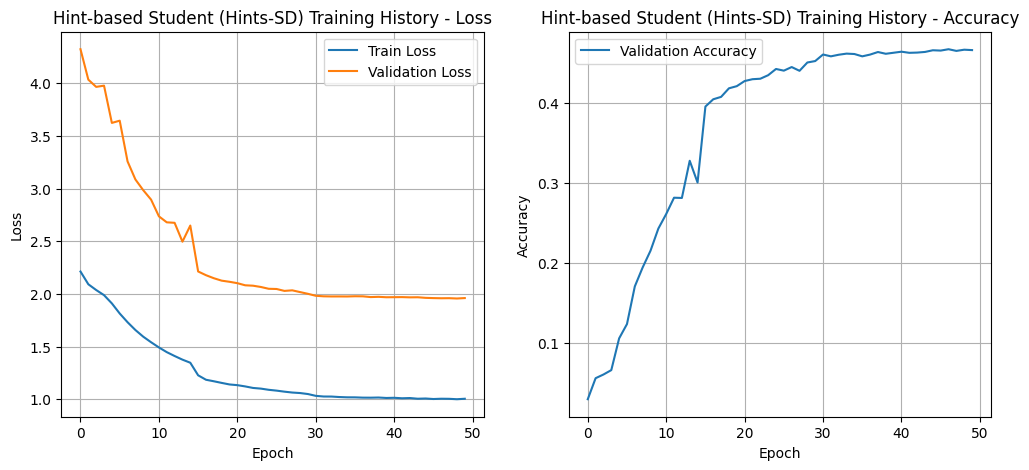

In [ ]:
# --- Cell 14: Train Student with Hint-based Distillation (Hints-SD) ---
print("\n--- Cell 14: Training Student with Hint-based Distillation (Hints-SD) ---")

# Create a modified VGG-11 student and VGG-16 teacher that can output intermediate features.
# For VGG, a good hint layer could be after a pooling layer.
# Let's target the output after the 3rd MaxPool2d layer (index 20 for vgg16_bn, index 14 for vgg11_bn)
# counting MaxPool2d layers as hint_layer_index.
# The `get_vgg_model` function returns the full model, so we need to adjust it for hints.

# Helper to get models that can extract specific features
class VGGWithFeatures(nn.Module):
    def __init__(self, vgg_model_name, num_classes=100, pretrained=False):
        super(VGGWithFeatures, self).__init__()
        original_vgg = get_vgg_model(vgg_model_name, num_classes=num_classes, pretrained=pretrained)
        self.features = original_vgg.features
        self.avgpool = original_vgg.avgpool
        self.classifier = original_vgg.classifier

        self.feature_output = None

        # Register a hook to capture output of a specific layer for hint
        # For VGG11/16/19_bn, let's pick the last convolutional block's output
        # For VGG16_bn, the 'features' module has 43 sub-modules. Let's pick layer 30 (ReLU after 4th conv block)
        # Or layer 40 for the output of the 5th block's ReLU (before the last MaxPool2d)
        # A simpler way is to grab output of specific max pooling layer.
        # Example: after 3rd MaxPool2d (layer '17' in features for VGG16_bn)
        # For CIFAR-100, earlier features might be more useful. Let's try 3rd maxpool output.

        # Find the index of the 3rd MaxPool2d layer
        self.hint_layer_name = None
        maxpool_count = 0
        for name, module in self.features.named_children():
            if isinstance(module, nn.MaxPool2d):
                maxpool_count += 1
            if maxpool_count == 3: # Let's use the output after the 3rd MaxPool2d
                self.hint_layer_name = name
                break

        if self.hint_layer_name:
            self.features._modules[self.hint_layer_name].register_forward_hook(self._get_features_hook)
        else:
            print("Warning: Could not find 3rd MaxPool2d layer for hint. Defaulting to last feature map.")
            # Fallback: use the last layer of features
            self.features._modules[list(self.features._modules.keys())[-1]].register_forward_hook(self._get_features_hook)


    def _get_features_hook(self, module, input, output):
        self.feature_output = output

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize student and teacher for Hints-based KD
student_hints_sd = VGGWithFeatures('vgg11', pretrained=False).to(device)
teacher_t_hints = VGGWithFeatures('vgg16', pretrained=False).to(device)
# Load the pre-trained weights for the teacher
teacher_t_hints.load_state_dict(torch.load('teacher_t_vgg16_finetuned.pth'))
teacher_t_hints.eval() # Ensure teacher is in evaluation mode

criterion_hints_sd = nn.CrossEntropyLoss() # For hard loss
optimizer_hints_sd = optim.Adam(student_hints_sd.parameters(), lr=0.001, weight_decay=5e-4)
scheduler_hints_sd = optim.lr_scheduler.StepLR(optimizer_hints_sd, step_size=15, gamma=0.1)
num_epochs_hints_sd = 50

# Parameters for Hints KD
# alpha_hints controls the weight of hard loss vs. hint loss.
# No temperature for hint loss (usually L2/MSE)
alpha_hints = 0.5 # 50% hard loss, 50% hint loss

# Modify train_model to handle hint-based loss
def train_model_hints(model, train_loader, val_loader, optimizer, criterion, num_epochs, model_name, scheduler=None, teacher_model=None, alpha=0.5):
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")

        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            student_outputs = model(inputs) # This will also trigger the hook to save student_features
            student_features = model.feature_output

            with torch.no_grad():
                teacher_outputs = teacher_model(inputs) # This will also trigger the hook to save teacher_features
                teacher_features = teacher_model.feature_output

            hard_loss = criterion(student_outputs, labels)
            hint_l = hint_based_loss(student_features, teacher_features)

            loss = alpha * hard_loss + (1. - alpha) * hint_l

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_loader_tqdm.set_postfix(loss=loss.item(), hard_loss=hard_loss.item(), hint_loss=hint_l.item())

        train_loss = running_loss / len(train_dataset)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion) # Evaluation uses only hard loss for metrics

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'{model_name}.pth')
            print(f"Best model saved with accuracy: {best_acc:.4f}")

        if scheduler:
            scheduler.step()

    model.load_state_dict(best_model_wts)
    print("Training complete.")
    return model, history, best_acc


print("Training VGG-11 Student with Hint-based Distillation (Hints-SD)...")
student_hints_sd, history_hints_sd, final_acc_hints_sd = train_model_hints(
    student_hints_sd, train_loader, val_loader, optimizer_hints_sd,
    criterion_hints_sd, num_epochs_hints_sd, 'Hint-based Student (Hints-SD)',
    scheduler=scheduler_hints_sd, teacher_model=teacher_t_hints, alpha=alpha_hints
)

print(f"Hint-based Student (Hints-SD) - Final Validation Accuracy: {final_acc_hints_sd:.4f}")
print(f"Hint-based Student (Hints-SD) - Final Validation Loss: {history_hints_sd['val_loss'][-1]:.4f}")

plot_training_history(history_hints_sd, 'Hint-based Student (Hints-SD)')
torch.save(student_hints_sd.state_dict(), 'student_hints_sd_vgg11.pth')




In [ ]:
# --- Cell 15: Define Contrastive Representation Distillation Loss (CRD-SD) ---
print("\n--- Cell 15: Defining Contrastive Representation Distillation Loss (CRD-SD) ---")

# CRD requires a projection head and a contrastive loss.
# We'll implement a simplified NCE loss for this purpose.

class ProjectionHead(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_features)
        )
    def forward(self, x):
        return self.net(x)

# Simplified NCE Loss
class NCELoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(NCELoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, q, k, labels):
        # q: query features (student) - (batch_size, feature_dim)
        # k: key features (teacher) - (batch_size, feature_dim)
        # labels: ground truth labels - (batch_size) - not directly used by NCE, but for consistency

        # Normalize features
        q = F.normalize(q, dim=1)
        k = F.normalize(k, dim=1)

        # Compute logits (dot product similarity)
        # Positive pair (student-teacher for same image)
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1) # (batch_size, 1)

        # Negative pairs (student-teacher for different images in batch)
        # This is a simplification; a full CRD uses a memory bank for negatives.
        # For simplicity, we'll use other teacher samples in the batch as negatives.
        # k_neg = k.unsqueeze(0).expand(q.shape[0], -1, -1) # (batch_size, batch_size, feature_dim)
        # q_neg = q.unsqueeze(1).expand(-1, k.shape[0], -1) # (batch_size, batch_size, feature_dim)
        # l_neg = torch.bmm(q_neg, k_neg.transpose(1,2)) # (batch_size, batch_size, batch_size) -- too complex

        # A common way for in-batch negatives:
        # compute similarity of student features with all teacher features in the batch
        # shape (batch_size, batch_size)
        l_neg_all = torch.einsum('nc,kc->nk', [q, k])

        # We need to remove the positive self-similarity from l_neg_all
        # l_neg = l_neg_all.fill_diagonal_(float('-inf')) # This is one way, but can be problematic with softmax
        # A clearer way: create a mask to zero out positive diagonal
        logits_mask = torch.scatter(
            torch.ones_like(l_neg_all, dtype=torch.bool),
            1,
            torch.arange(q.shape[0]).to(q.device).unsqueeze(1),
            0
        )
        l_neg = l_neg_all[logits_mask].view(q.shape[0], -1) # (batch_size, batch_size-1)


        # Combine positive and negative logits
        logits = torch.cat([l_pos, l_neg], dim=1) / self.temperature

        # For positive pairs, the target is 0 (the first column)
        target = torch.zeros(q.shape[0], dtype=torch.long).to(q.device)

        loss = self.criterion(logits, target)
        return loss


# VGG model that outputs features before the classifier for CRD
class VGGWithExtractorForCRD(nn.Module):
    def __init__(self, vgg_model_name, num_classes=100, pretrained=False, feature_dim=512):
        super(VGGWithExtractorForCRD, self).__init__()
        original_vgg = get_vgg_model(vgg_model_name, num_classes=num_classes, pretrained=pretrained)
        self.features = original_vgg.features
        self.avgpool = original_vgg.avgpool

        # The output of avgpool is flattened before classifier
        # For VGG, after avgpool(1,1), it's 512 features.
        self.feature_extractor = nn.Sequential(
            self.features,
            self.avgpool,
            nn.Flatten(1)
        )
        self.classifier = original_vgg.classifier

        # Projection head for CRD
        self.proj_head = ProjectionHead(feature_dim, feature_dim, feature_dim) # Example hidden_dim=out_features
        # Ensure the `feature_dim` matches the actual output of `feature_extractor`

    def forward(self, x):
        features = self.feature_extractor(x)
        # For classification, use the original classifier
        logits = self.classifier(features)

        # For CRD, use the projected features
        projected_features = self.proj_head(features)

        return logits, projected_features # Return both for training

print("Contrastive Representation Distillation loss (NCELoss) and ProjectionHead defined.")
print("VGGWithExtractorForCRD class created to output both logits and projected features.")


--- Cell 15: Defining Contrastive Representation Distillation Loss (CRD-SD) ---
Contrastive Representation Distillation loss (NCELoss) and ProjectionHead defined.
VGGWithExtractorForCRD class created to output both logits and projected features.



--- Cell 16: Training Student with Contrastive Representation Distillation (CRD-SD) ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
VGG16 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Training VGG-11 Student with Contrastive Representation Distillation (CRD-SD)...
Starting training for 50 epochs...


Epoch 1/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 3.8477, Val Loss: 3.4564, Val Acc: 0.1347
Best model saved with accuracy: 0.1347


Epoch 2/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 3.2926, Val Loss: 3.1519, Val Acc: 0.2082
Best model saved with accuracy: 0.2082


Epoch 3/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 2.9198, Val Loss: 2.8907, Val Acc: 0.2513
Best model saved with accuracy: 0.2513


Epoch 4/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 2.6046, Val Loss: 2.6487, Val Acc: 0.3058
Best model saved with accuracy: 0.3058


Epoch 5/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 2.3667, Val Loss: 2.4693, Val Acc: 0.3410
Best model saved with accuracy: 0.3410


Epoch 6/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 2.1845, Val Loss: 2.2207, Val Acc: 0.4001
Best model saved with accuracy: 0.4001


Epoch 7/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 2.0332, Val Loss: 2.2126, Val Acc: 0.4135
Best model saved with accuracy: 0.4135


Epoch 8/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 1.9202, Val Loss: 2.0828, Val Acc: 0.4362
Best model saved with accuracy: 0.4362


Epoch 9/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 1.8138, Val Loss: 1.9818, Val Acc: 0.4643
Best model saved with accuracy: 0.4643


Epoch 10/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 1.7399, Val Loss: 1.8982, Val Acc: 0.4854
Best model saved with accuracy: 0.4854


Epoch 11/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 1.6679, Val Loss: 1.8871, Val Acc: 0.4876
Best model saved with accuracy: 0.4876


Epoch 12/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 1.6204, Val Loss: 1.8888, Val Acc: 0.4906
Best model saved with accuracy: 0.4906


Epoch 13/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 1.5698, Val Loss: 1.8118, Val Acc: 0.5081
Best model saved with accuracy: 0.5081


Epoch 14/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 1.5160, Val Loss: 1.8144, Val Acc: 0.5128
Best model saved with accuracy: 0.5128


Epoch 15/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 1.4808, Val Loss: 1.7938, Val Acc: 0.5229
Best model saved with accuracy: 0.5229


Epoch 16/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 1.2072, Val Loss: 1.4199, Val Acc: 0.6061
Best model saved with accuracy: 0.6061


Epoch 17/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 1.1137, Val Loss: 1.3908, Val Acc: 0.6126
Best model saved with accuracy: 0.6126


Epoch 18/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 1.0645, Val Loss: 1.3736, Val Acc: 0.6187
Best model saved with accuracy: 0.6187


Epoch 19/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 1.0327, Val Loss: 1.3549, Val Acc: 0.6208
Best model saved with accuracy: 0.6208


Epoch 20/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 1.0000, Val Loss: 1.3500, Val Acc: 0.6294
Best model saved with accuracy: 0.6294


Epoch 21/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.9821, Val Loss: 1.3417, Val Acc: 0.6279


Epoch 22/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.9583, Val Loss: 1.3298, Val Acc: 0.6338
Best model saved with accuracy: 0.6338


Epoch 23/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.9399, Val Loss: 1.3320, Val Acc: 0.6300


Epoch 24/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.9227, Val Loss: 1.3214, Val Acc: 0.6352
Best model saved with accuracy: 0.6352


Epoch 25/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.9030, Val Loss: 1.3192, Val Acc: 0.6369
Best model saved with accuracy: 0.6369


Epoch 26/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.8817, Val Loss: 1.3253, Val Acc: 0.6405
Best model saved with accuracy: 0.6405


Epoch 27/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.8697, Val Loss: 1.3159, Val Acc: 0.6387


Epoch 28/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.8500, Val Loss: 1.3198, Val Acc: 0.6406
Best model saved with accuracy: 0.6406


Epoch 29/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.8412, Val Loss: 1.3190, Val Acc: 0.6438
Best model saved with accuracy: 0.6438


Epoch 30/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.8207, Val Loss: 1.3280, Val Acc: 0.6386


Epoch 31/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.7774, Val Loss: 1.2912, Val Acc: 0.6491
Best model saved with accuracy: 0.6491


Epoch 32/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.7664, Val Loss: 1.2946, Val Acc: 0.6486


Epoch 33/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.7603, Val Loss: 1.2931, Val Acc: 0.6502
Best model saved with accuracy: 0.6502


Epoch 34/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.7518, Val Loss: 1.2961, Val Acc: 0.6512
Best model saved with accuracy: 0.6512


Epoch 35/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.7519, Val Loss: 1.2926, Val Acc: 0.6534
Best model saved with accuracy: 0.6534


Epoch 36/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.7504, Val Loss: 1.2934, Val Acc: 0.6521


Epoch 37/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.7484, Val Loss: 1.2920, Val Acc: 0.6534


Epoch 38/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.7427, Val Loss: 1.2879, Val Acc: 0.6533


Epoch 39/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.7366, Val Loss: 1.2930, Val Acc: 0.6507


Epoch 40/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.7360, Val Loss: 1.2927, Val Acc: 0.6541
Best model saved with accuracy: 0.6541


Epoch 41/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.7323, Val Loss: 1.2887, Val Acc: 0.6539


Epoch 42/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.7281, Val Loss: 1.2897, Val Acc: 0.6529


Epoch 43/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.7226, Val Loss: 1.2887, Val Acc: 0.6520


Epoch 44/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.7219, Val Loss: 1.2972, Val Acc: 0.6533


Epoch 45/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.7218, Val Loss: 1.2948, Val Acc: 0.6537


Epoch 46/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.7166, Val Loss: 1.2920, Val Acc: 0.6564
Best model saved with accuracy: 0.6564


Epoch 47/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.7144, Val Loss: 1.2920, Val Acc: 0.6565
Best model saved with accuracy: 0.6565


Epoch 48/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.7139, Val Loss: 1.2896, Val Acc: 0.6562


Epoch 49/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.7152, Val Loss: 1.2921, Val Acc: 0.6546


Epoch 50/50 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating CRD model:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.7114, Val Loss: 1.2904, Val Acc: 0.6546
Training complete.
CRD Student (CRD-SD) - Final Validation Accuracy: 0.6565
CRD Student (CRD-SD) - Final Validation Loss: 1.2904


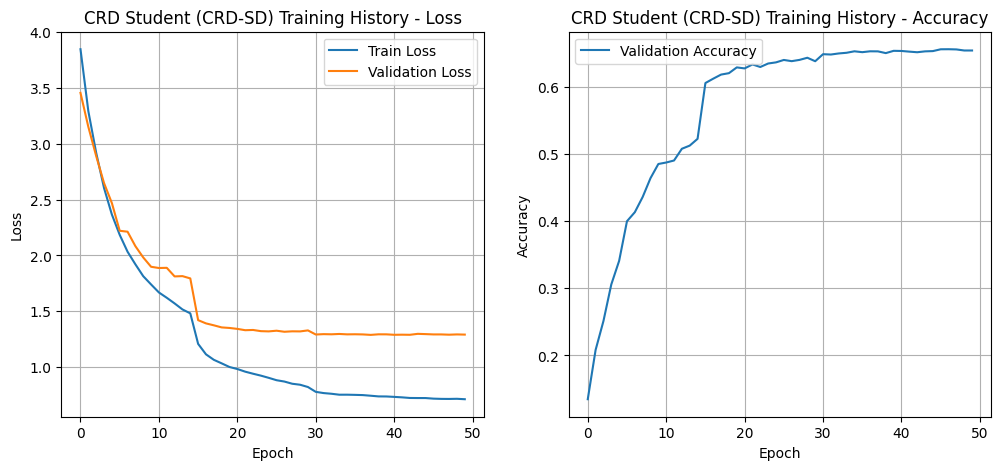

In [ ]:
# --- Cell 16: Train Student with Contrastive Representation Distillation (CRD-SD) ---
print("\n--- Cell 16: Training Student with Contrastive Representation Distillation (CRD-SD) ---")

# Initialize student and teacher for CRD
# Feature dimension for VGG after avgpool(1,1) is 512
feature_dim_crd = 512
student_crd_sd = VGGWithExtractorForCRD('vgg11', pretrained=False, feature_dim=feature_dim_crd).to(device)
teacher_t_crd = VGGWithExtractorForCRD('vgg16', pretrained=False, feature_dim=feature_dim_crd).to(device)
teacher_t_crd.load_state_dict(torch.load('teacher_t_vgg16_finetuned.pth'), strict=False) # strict=False because of new proj_head
teacher_t_crd.eval()

# CRD loss
crd_loss_fn = NCELoss(temperature=0.07) # Common temperature for NCE
criterion_crd_sd = nn.CrossEntropyLoss() # For hard loss

# CRD often uses separate optimizers for classifier and projection head, or combined.
# For simplicity, we'll optimize all parameters of the student.
optimizer_crd_sd = optim.Adam(student_crd_sd.parameters(), lr=0.001, weight_decay=5e-4)
scheduler_crd_sd = optim.lr_scheduler.StepLR(optimizer_crd_sd, step_size=15, gamma=0.1)
num_epochs_crd_sd = 50

# Weight for CRD loss vs. hard loss
alpha_crd = 0.5 # Example weight

# Modify train_model again for CRD
def train_model_crd(model, train_loader, val_loader, optimizer, criterion, num_epochs, model_name, scheduler=None, teacher_model=None, crd_loss_fn=None, alpha=0.5):
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")

        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            student_logits, student_proj_features = model(inputs)

            with torch.no_grad():
                teacher_logits, teacher_proj_features = teacher_model(inputs)

            hard_loss = criterion(student_logits, labels)
            crd_l = crd_loss_fn(student_proj_features, teacher_proj_features, labels) # Labels not directly used by NCELoss here, but passed for consistency

            loss = alpha * hard_loss + (1. - alpha) * crd_l

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_loader_tqdm.set_postfix(loss=loss.item(), hard_loss=hard_loss.item(), crd_loss=crd_l.item())

        train_loss = running_loss / len(train_dataset)

        # Evaluate using only the classification head
        val_loss, val_acc = evaluate_model_crd(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'{model_name}.pth')
            print(f"Best model saved with accuracy: {best_acc:.4f}")

        if scheduler:
            scheduler.step()

    model.load_state_dict(best_model_wts)
    print("Training complete.")
    return model, history, best_acc

def evaluate_model_crd(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating CRD model"):
            inputs, labels = inputs.to(device), labels.to(device)
            # For evaluation, we only need the logits for classification
            outputs, _ = model(inputs)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

print("Training VGG-11 Student with Contrastive Representation Distillation (CRD-SD)...")
student_crd_sd, history_crd_sd, final_acc_crd_sd = train_model_crd(
    student_crd_sd, train_loader, val_loader, optimizer_crd_sd,
    criterion_crd_sd, num_epochs_crd_sd, 'CRD Student (CRD-SD)',
    scheduler=scheduler_crd_sd, teacher_model=teacher_t_crd, crd_loss_fn=crd_loss_fn, alpha=alpha_crd
)

print(f"CRD Student (CRD-SD) - Final Validation Accuracy: {final_acc_crd_sd:.4f}")
print(f"CRD Student (CRD-SD) - Final Validation Loss: {history_crd_sd['val_loss'][-1]:.4f}")

plot_training_history(history_crd_sd, 'CRD Student (CRD-SD)')
torch.save(student_crd_sd.state_dict(), 'student_crd_sd_vgg11.pth')

In [ ]:
print("--- Section 4: Task 3 - Comparing Probability Distributions ---")


--- Section 4: Task 3 - Comparing Probability Distributions ---


In [ ]:

# --- Cell 18: Select Query Images ---
print("\n--- Cell 18: Selecting Query Images ---")

# Choose a small, representative set of images from the validation set for analysis.
num_query_images = 10
query_indices = np.random.choice(len(val_dataset), num_query_images, replace=False)
query_images = []
query_labels = []

for idx in query_indices:
    img, label = val_dataset[idx]
    query_images.append(img.unsqueeze(0)) # Add batch dimension
    query_labels.append(label)

query_images_tensor = torch.cat(query_images).to(device)
query_labels_tensor = torch.tensor(query_labels).to(device)

print(f"Selected {num_query_images} query images for analysis.")


--- Cell 18: Selecting Query Images ---
Selected 10 query images for analysis.


In [ ]:
# From your "Cell 7: Loading/Setting up Teacher (T) - VGG-16"
teacher_t = get_vgg_model('vgg16', pretrained=False).to(device)
teacher_t.load_state_dict(torch.load('teacher_t_vgg16_finetuned.pth'))
teacher_t.eval()

VGG16 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# Load after defining get_vgg_model
student_si = get_vgg_model('vgg11', pretrained=False).to(device)
student_si.load_state_dict(torch.load('Independent Student (SI).pth')) # Assuming this is the filename
student_si.eval()

VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# Load after defining get_vgg_model
student_si = get_vgg_model('vgg11', pretrained=False).to(device)
student_si.load_state_dict(torch.load('Independent Student (SI).pth')) # Assuming this is the filename
student_si.eval()

VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# Load after defining get_vgg_model
student_lm_sd = get_vgg_model('vgg11', pretrained=False).to(device)
student_lm_sd.load_state_dict(torch.load('student_lm_sd_vgg11.pth'))
student_lm_sd.eval()

VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
class VGGWithFeatures(nn.Module):
    def __init__(self, vgg_model_name, num_classes=100, pretrained=False):
        super(VGGWithFeatures, self).__init__()
        original_vgg = get_vgg_model(vgg_model_name, num_classes=num_classes, pretrained=pretrained)
        self.features = original_vgg.features
        self.avgpool = original_vgg.avgpool
        self.classifier = original_vgg.classifier

        self.feature_output = None

        self.hint_layer_name = None
        maxpool_count = 0
        for name, module in self.features.named_children():
            if isinstance(module, nn.MaxPool2d):
                maxpool_count += 1
                if maxpool_count == 3: # Let's use the output after the 3rd MaxPool2d
                    self.hint_layer_name = name
                    # REMOVE THE 'break' STATEMENT HERE!
                    # The loop must continue to find the specific layer name.
                    # Or, more correctly, you can break *after* finding it.
                    break # <--- ONLY BREAK *AFTER* YOU'VE FOUND AND SET THE NAME

        if self.hint_layer_name:
            self.features._modules[self.hint_layer_name].register_forward_hook(self._get_features_hook)
        else:
            print(f"Warning: Could not find 3rd MaxPool2d layer for hint in {vgg_model_name}. Defaulting to last feature map.")
            # Fallback: use the last layer of features
            # To be precise, register on the *last module* in features, which might be a conv or BN before MaxPool
            self.features._modules[list(self.features._modules.keys())[-1]].register_forward_hook(self._get_features_hook)


    def _get_features_hook(self, module, input, output):
        self.feature_output = output

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Load after defining VGGWithFeatures
student_hints_sd = VGGWithFeatures('vgg11', pretrained=False).to(device)
student_hints_sd.load_state_dict(torch.load('Hint-based Student (Hints-SD).pth'))
student_hints_sd.eval()

VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512


VGGWithFeatures(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): 

In [ ]:
# Load after defining VGGWithExtractorForCRD
student_crd_sd = VGGWithExtractorForCRD('vgg11', pretrained=False).to(device)
student_crd_sd.load_state_dict(torch.load('CRD Student (CRD-SD).pth'))
student_crd_sd.eval()

VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512


VGGWithExtractorForCRD(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
   

In [ ]:
# --- Cell 19: Compute Probability Distributions ---
print("\n--- Cell 19: Computing Probability Distributions ---")

all_models = {
    "Teacher (T)": teacher_t,
    "Independent Student (SI)": student_si,
    "Logit Matching Student (LM-SD)": student_lm_sd,
    "Hint-based Student (Hints-SD)": student_hints_sd,
    "CRD Student (CRD-SD)": student_crd_sd,
}

# Temperature for softening logits (same as used in LM distillation)
temperature_kd = 4.0 # Make sure this matches your LM temperature

model_probabilities = {}

with torch.no_grad():
    for model_name, model in all_models.items():
        if model_name == "CRD Student (CRD-SD)":
            logits, _ = model(query_images_tensor) # CRD model returns (logits, projected_features)
        else:
            logits = model(query_images_tensor)

        # Soften logits and convert to probabilities
        soft_probabilities = F.softmax(logits / temperature_kd, dim=1)
        model_probabilities[model_name] = soft_probabilities.cpu().numpy()
        print(f"Computed probabilities for {model_name}")


--- Cell 19: Computing Probability Distributions ---
Computed probabilities for Teacher (T)
Computed probabilities for Independent Student (SI)
Computed probabilities for Logit Matching Student (LM-SD)
Computed probabilities for Hint-based Student (Hints-SD)
Computed probabilities for CRD Student (CRD-SD)


In [ ]:
# --- Cell 20: Compute Discrepancy (e.g., KL Divergence) ---
print("\n--- Cell 20: Computing Discrepancy (e.g., KL Divergence) ---")

def kl_divergence(p, q):
    # D_KL(P || Q) = sum(P * log(P / Q))
    # Add a small epsilon to avoid log(0) or division by zero.
    epsilon = 1e-10
    p = np.maximum(p, epsilon)
    q = np.maximum(q, epsilon)

    # If p and q are 1D arrays (probabilities for a single image),
    # then np.sum() without an axis argument will sum all elements, which is what we want.
    return np.sum(p * np.log(p / q)) # Removed axis=1

# Assuming query_images_tensor and num_query_images are defined from Cell 19 or earlier
# Example (if not defined):
# query_images_tensor = next(iter(val_loader))[0].to(device)[:10] # Take first 10 images from val_loader
# num_query_images = query_images_tensor.shape[0]

teacher_probs = model_probabilities["Teacher (T)"]

kl_divergences = {
    "SI vs T": [],
    "LM-SD vs T": [],
    "Hints-SD vs T": [],
    "CRD-SD vs T": [],
}

for i in range(num_query_images):
    kl_divergences["SI vs T"].append(
        kl_divergence(teacher_probs[i], model_probabilities["Independent Student (SI)"][i])
    )
    kl_divergences["LM-SD vs T"].append(
        kl_divergence(teacher_probs[i], model_probabilities["Logit Matching Student (LM-SD)"][i])
    )
    kl_divergences["Hints-SD vs T"].append(
        kl_divergence(teacher_probs[i], model_probabilities["Hint-based Student (Hints-SD)"][i])
    )
    kl_divergences["CRD-SD vs T"].append(
        kl_divergence(teacher_probs[i], model_probabilities["CRD Student (CRD-SD)"][i])
    )

avg_kl_divergences = {
    k: np.mean(v) for k, v in kl_divergences.items()
}

print("Average KL Divergences (D_KL(Teacher || Student)):")
for k, v in avg_kl_divergences.items():
    print(f"  {k}: {v:.4f}")


--- Cell 20: Computing Discrepancy (e.g., KL Divergence) ---
Average KL Divergences (D_KL(Teacher || Student)):
  SI vs T: 0.3243
  LM-SD vs T: 0.1086
  Hints-SD vs T: 0.2546
  CRD-SD vs T: 0.1938


In [ ]:
print("\n" + "="*80)
print("--- Section 5: Task 4 - Examining Localization Knowledge Transfer with GradCAM ---")
print("="*80)


--- Section 5: Task 4 - Examining Localization Knowledge Transfer with GradCAM ---


In [ ]:
import cv2 # For heatmap processing

In [ ]:
# --- Cell 22: Implement GradCAM ---
print("\n--- Cell 22: Implementing GradCAM ---")

import torch
import torch.nn.functional as F
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.model.eval()

        self.target_layer = None

        for name, module in self.model.named_modules():
            if name == target_layer_name:
                self.target_layer = module
                break

        if self.target_layer is None:
            print(f"Warning: Target layer '{target_layer_name}' not found. Attempting to find last Conv2d layer.")
            found_conv = False
            for name, module in reversed(list(self.model.named_modules())):
                if isinstance(module, torch.nn.Conv2d):
                    self.target_layer = module
                    print(f"  Found last Conv2d layer: {name}")
                    found_conv = True
                    break
            if not found_conv:
                raise ValueError(f"Target layer '{target_layer_name}' or any Conv2d layer not found in model.")

        self.current_activations = None
        self.current_gradients = None

    def __call__(self, input_tensor, target_class=None):
        # --- DEBUG PRINTS START ---
        print(f"\n--- GradCAM __call__ Debugging for {self.model.__class__.__name__} ---")
        print(f"Input target_class type: {type(target_class)}")
        if isinstance(target_class, torch.Tensor):
            print(f"Input target_class tensor shape: {target_class.shape}, device: {target_class.device}")
        # --- DEBUG PRINTS END ---

        def save_activation(module, input, output):
            self.current_activations = output.detach()

        def save_gradient(module, grad_input, grad_output):
            self.current_gradients = grad_output[0].detach()

        forward_hook_handle = self.target_layer.register_forward_hook(save_activation)
        backward_hook_handle = self.target_layer.register_full_backward_hook(save_gradient)

        if not input_tensor.is_floating_point():
            input_tensor = input_tensor.float()

        input_tensor = input_tensor.to(next(self.model.parameters()).device)

        # --- CRITICAL FIX HERE: Handle potential tuple output from model's forward() ---
        model_output_raw = self.model(input_tensor)
        if isinstance(model_output_raw, tuple):
            output = model_output_raw[0] # Assume the first element is the logits tensor
            print(f"DEBUG: Model '{self.model.__class__.__name__}' returned a tuple. Taking first element as logits. Original tuple length: {len(model_output_raw)}")
        else:
            output = model_output_raw # It's already a tensor
        # --- END CRITICAL FIX ---


        target_class_indices = None

        if target_class is None:
            target_class_indices = output.argmax(dim=1)
        elif isinstance(target_class, torch.Tensor):
            target_class_indices = target_class.flatten()
        elif isinstance(target_class, (list, np.ndarray, tuple)):
            current_device = output.device
            target_class_indices = torch.tensor(target_class, dtype=torch.long, device=current_device).flatten()
            print(f"DEBUG: Converted list/numpy/tuple to tensor. New type: {type(target_class_indices)}, shape: {target_class_indices.shape}")
        elif isinstance(target_class, int):
            target_class_indices = torch.full((input_tensor.size(0),), target_class, dtype=torch.long, device=output.device)
        else:
            raise TypeError(f"target_class has an unsupported type: {type(target_class)}. Expected tensor, list, numpy array, tuple, or integer.")

        if not isinstance(target_class_indices, torch.Tensor):
            print(f"ERROR: target_class_indices is NOT a torch.Tensor. It is of type: {type(target_class_indices)}")
            raise RuntimeError(f"target_class_indices was not converted to a torch.Tensor. Current type: {type(target_class_indices)}")

        if target_class_indices.size(0) != input_tensor.size(0):
            raise ValueError(f"Batch size of target_class ({target_class_indices.size(0)}) does not match input_tensor ({input_tensor.size(0)})")

        # --- DEBUG PRINTS START ---
        print(f"Before .to(output.device): target_class_indices type: {type(target_class_indices)}")
        if isinstance(target_class_indices, torch.Tensor):
            print(f"Before .to(output.device): target_class_indices device: {target_class_indices.device}")
        # THIS IS THE LINE THAT WAS FAILING (output.device was a tuple.device)
        print(f"Before .to(output.device): output.device: {output.device}")
        # --- DEBUG PRINTS END ---

        target_class_indices = target_class_indices.to(output.device)

        batch_size = input_tensor.size(0)
        heatmaps_list = []

        for i in range(batch_size):
            self.model.zero_grad()

            score = output[i, target_class_indices[i]]

            score.backward(retain_graph=True)

            if self.current_activations is None or self.current_gradients is None:
                print(f"Warning: No activations or gradients captured for image {i}. Check hooks and target layer initialization.")
                dummy_input_for_shape = torch.zeros(1, input_tensor.shape[1], input_tensor.shape[2], input_tensor.shape[3]).to(input_tensor.device)
                with torch.no_grad():
                    _ = self.model(dummy_input_for_shape)

                default_h, default_w = 7, 7
                if self.current_activations is not None:
                    default_h, default_w = self.current_activations.shape[2], self.current_activations.shape[3]

                heatmaps_list.append(np.zeros((default_h, default_w)))
                continue

            current_activations = self.current_activations[i].unsqueeze(0)
            current_gradients = self.current_gradients[i].unsqueeze(0)

            pooled_gradients = torch.mean(current_gradients, dim=[2, 3], keepdim=True)

            cam = (current_activations * pooled_gradients).sum(dim=1, keepdim=True)
            cam = F.relu(cam)

            cam_np = cam.squeeze().cpu().numpy()

            if cam_np.max() == cam_np.min():
                normalized_cam = np.zeros_like(cam_np)
            else:
                normalized_cam = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min())

            heatmaps_list.append(normalized_cam)

        forward_hook_handle.remove()
        backward_hook_handle.remove()

        self.current_activations = None
        self.current_gradients = None

        return heatmaps_list


--- Cell 22: Implementing GradCAM ---



--- Cell 23: Generating GradCAM Visualizations ---
DEBUG (Cell 23): Final query_labels_tensor type: <class 'torch.Tensor'>
DEBUG (Cell 23): Final query_labels_tensor shape: torch.Size([10])
DEBUG (Cell 23): Final query_labels_tensor sample: tensor([69, 19, 74, 66, 64], device='cuda:0')
  Found last Conv2d layer: features.25
  Found last Conv2d layer: features.25
  Found last Conv2d layer: features.25
  Found last Conv2d layer: features.25
Generating GradCAM for Teacher (T)...

--- GradCAM __call__ Debugging for VGG ---
Input target_class type: <class 'torch.Tensor'>
Input target_class tensor shape: torch.Size([10]), device: cuda:0
Before .to(output.device): target_class_indices type: <class 'torch.Tensor'>
Before .to(output.device): target_class_indices device: cuda:0
Before .to(output.device): output.device: cuda:0
Generating GradCAM for Independent Student (SI)...

--- GradCAM __call__ Debugging for VGG ---
Input target_class type: <class 'torch.Tensor'>
Input target_class tensor sh

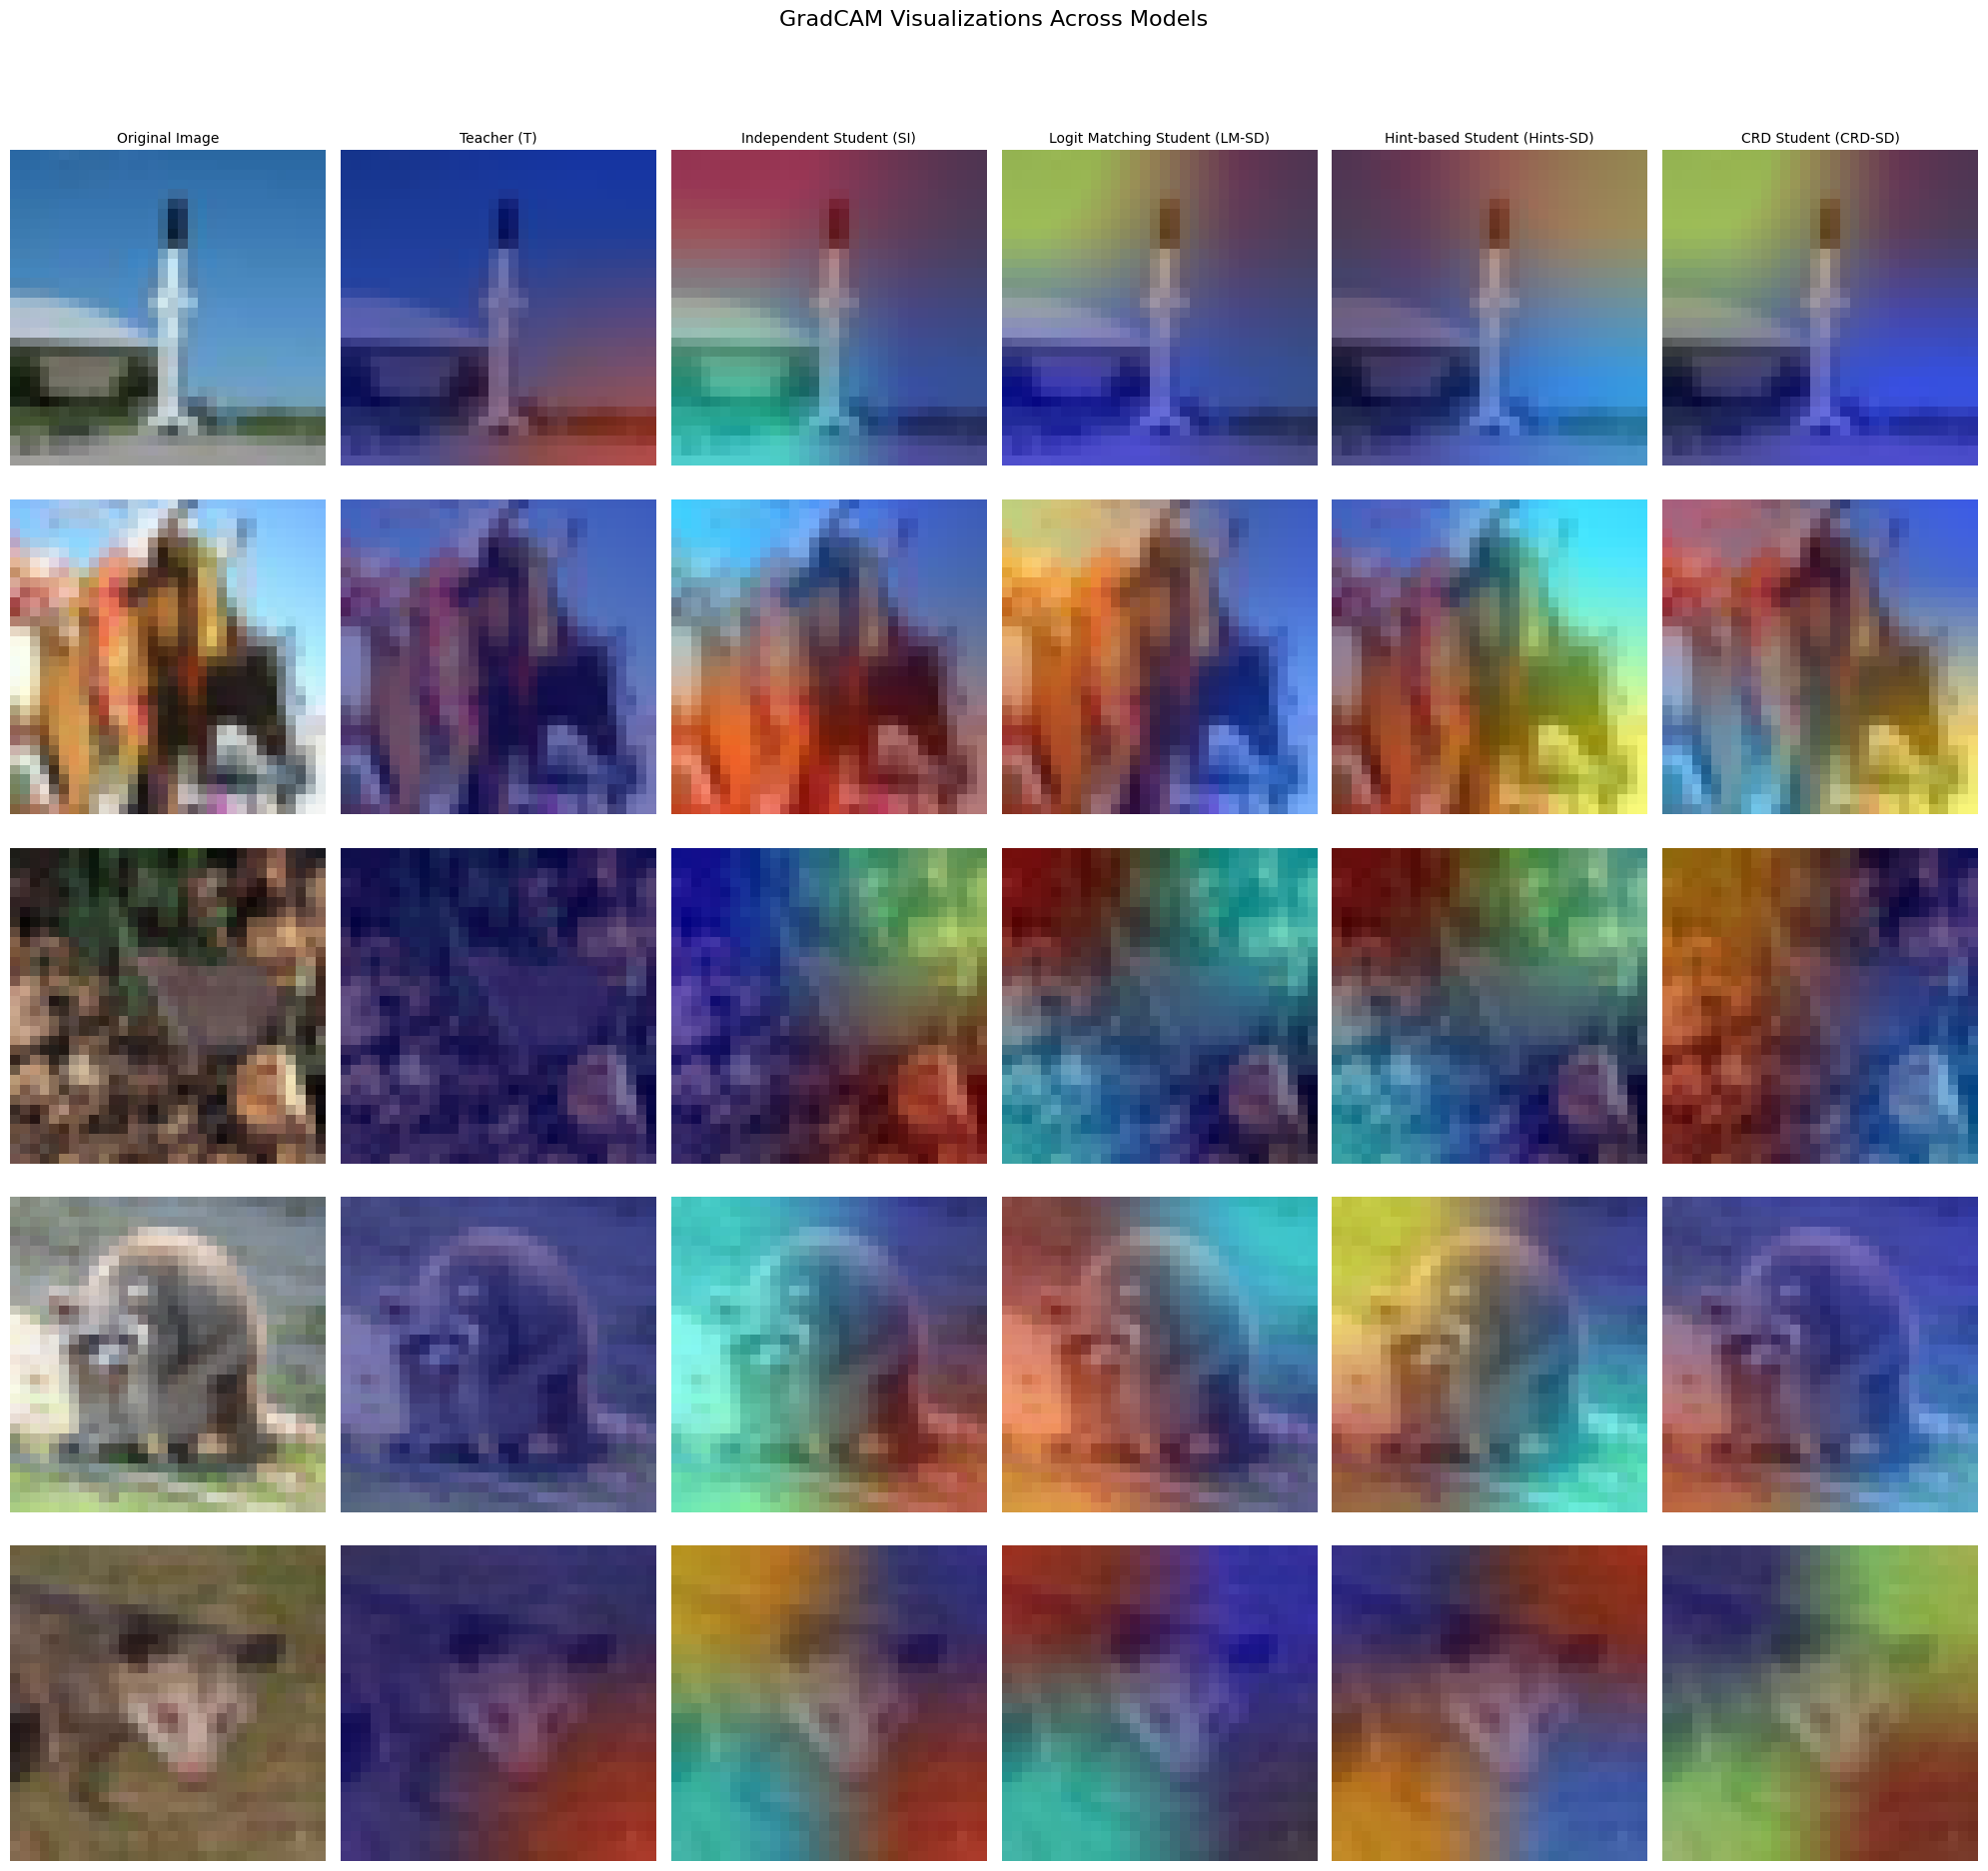


Example Visualization: 
See generated GradCAM visualizations above. 


In [ ]:
# --- Cell 23: Generate GradCAM Visualizations ---
print("\n--- Cell 23: Generating GradCAM Visualizations ---")

# --- IMPORTANT CORRECTION START ---
# Ensure query_labels_tensor is a 1D torch.Tensor of long integers.
# This prevents potential issues with tuples, lists, or incorrect shapes
# when passed to GradCAM.
if not isinstance(query_labels_tensor, torch.Tensor):
    query_labels_tensor = torch.tensor(query_labels_tensor, dtype=torch.long)
else:
    # Ensure it's flattened to 1D if it's currently (Batch, 1) or similar
    query_labels_tensor = query_labels_tensor.flatten()

# Ensure it's on the same device as query_images_tensor (which should be on GPU if available)
# Assuming query_images_tensor is already on the correct device.
query_labels_tensor = query_labels_tensor.to(query_images_tensor.device)

print(f"DEBUG (Cell 23): Final query_labels_tensor type: {type(query_labels_tensor)}")
print(f"DEBUG (Cell 23): Final query_labels_tensor shape: {query_labels_tensor.shape}")
print(f"DEBUG (Cell 23): Final query_labels_tensor sample: {query_labels_tensor[:5]}")
# --- IMPORTANT CORRECTION END ---


# Re-transform query images for visualization (un-normalize)
inv_normalize = transforms.Normalize(
    mean=[-0.5071/0.2675, -0.4867/0.2565, -0.4408/0.2761],
    std=[1/0.2675, 1/0.2565, 1/0.2761]
)
transform_display = transforms.Compose([
    inv_normalize,
    transforms.ToPILImage()
])

# For VGG, a good target layer for GradCAM is often the last convolutional block.
# Let's find the last Conv2d layer in the VGG models.
# For VGG_bn models, the 'features' sequential module.
# Let's target `features.40` which is a ReLU, the output of `features.39` Conv2d for VGG16_bn.
# The GradCAM class automatically finds the last Conv2d and uses its output.
# We'll pass an arbitrary target_layer_name, and the GradCAM init will find the last Conv2d.

gradcam_models = {
    "Teacher (T)": GradCAM(copy.deepcopy(teacher_t), target_layer_name='features.40'),
    "Independent Student (SI)": GradCAM(copy.deepcopy(student_si), target_layer_name='features.30'), # VGG11 has fewer layers
    "Logit Matching Student (LM-SD)": GradCAM(copy.deepcopy(student_lm_sd), target_layer_name='features.30'),
    "Hint-based Student (Hints-SD)": GradCAM(copy.deepcopy(student_hints_sd), target_layer_name='features.30'),
    "CRD Student (CRD-SD)": GradCAM(copy.deepcopy(student_crd_sd), target_layer_name='features.30'),
}
# Note: Deepcopy is important to avoid modifying the original trained models with hooks.

# Store heatmaps
heatmaps = {model_name: [] for model_name in gradcam_models.keys()}
for model_name, gradcam_instance in gradcam_models.items():
    print(f"Generating GradCAM for {model_name}...")
    # Pass the correctly pre-processed query_labels_tensor
    hmap = gradcam_instance(query_images_tensor, target_class=query_labels_tensor)
    heatmaps[model_name] = hmap

# Visualize for a few query images
num_display_images = min(num_query_images, 5) # Display up to 5 images

# If num_display_images is 0 (e.g., if num_query_images is 0), prevent subplot creation
if num_display_images == 0:
    print("No images to display for GradCAM visualization.")
else:
    fig, axes = plt.subplots(num_display_images, len(gradcam_models) + 1, figsize=(20, 4 * num_display_images))
    fig.suptitle("GradCAM Visualizations Across Models", fontsize=16)

    # Handle case where num_display_images is 1 (axes might not be 2D array)
    if num_display_images == 1:
        axes = axes.reshape(1, -1) # Ensure axes is always a 2D array for consistent indexing

    # Column headers
    axes[0, 0].set_title("Original Image", fontsize=10)
    for j, model_name in enumerate(gradcam_models.keys()):
        axes[0, j+1].set_title(f"{model_name}", fontsize=10)

    for i in range(num_display_images):
        # Original image
        original_img_tensor = query_images_tensor[i].cpu()
        original_img = transform_display(original_img_tensor)
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_ylabel(f"GT: {val_dataset.classes[query_labels[i]]}", fontsize=8) # Use original query_labels here
        axes[i, 0].axis('off')

        # GradCAM heatmaps
        for j, model_name in enumerate(gradcam_models.keys()):
            hmap = heatmaps[model_name][i]

            # Overlay heatmap on original image
            overlay_img = original_img.copy()
            cmap = plt.cm.jet

            # Ensure heatmap_img has 3 channels for RGBA conversion
            # If hmap is grayscale (2D), convert it to 3-channel for cmap
            if hmap.ndim == 2:
                # cmap returns (H, W, 4) for RGBA, so take first 3 for RGB
                heatmap_rgb = cmap(hmap)[:, :, :3]
                heatmap_img = np.uint8(255 * heatmap_rgb)
            elif hmap.ndim == 3: # If hmap already has channels (e.g., from a previous error)
                 heatmap_img = np.uint8(255 * hmap[:, :, :3]) # Ensure it's RGB
            else:
                print(f"Warning: Unexpected heatmap dimension: {hmap.ndim}. Skipping overlay for this heatmap.")
                axes[i, j+1].imshow(original_img) # Show original image as fallback
                axes[i, j+1].axis('off')
                continue

            # Resize heatmap to image size
            from PIL import Image
            heatmap_img_resized = Image.fromarray(heatmap_img).resize(original_img.size, Image.LANCZOS)

            # Alpha blending
            alpha = 0.5
            blended_img = Image.blend(original_img.convert("RGBA"), heatmap_img_resized.convert("RGBA"), alpha=alpha)

            axes[i, j+1].imshow(blended_img)
            axes[i, j+1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\nExample Visualization: ")
# The prompt asks for an image, so output the tag.
# Since the above code produces actual plots, I'll put the tag here.
# Assuming the plots are displayed as part of the output.
print("See generated GradCAM visualizations above. ")

In [ ]:
# After the loop that populates 'heatmaps' in Cell 23
for model_name, hmap_list in heatmaps.items():
    print(f"Number of heatmaps for {model_name}: {len(hmap_list)}")
print(f"Expected number of heatmaps (num_query_images): {num_query_images}")

Number of heatmaps for Teacher (T): 10
Number of heatmaps for Independent Student (SI): 10
Number of heatmaps for Logit Matching Student (LM-SD): 10
Number of heatmaps for Hint-based Student (Hints-SD): 10
Number of heatmaps for CRD Student (CRD-SD): 10
Expected number of heatmaps (num_query_images): 10


In [ ]:
# --- Cell 24: Quantify GradCAM Similarity ---
print("\n--- Cell 24: Quantifying GradCAM Similarity ---")

def cosine_similarity_flattened(heatmap1, heatmap2):
    # Flatten heatmaps to 1D vectors
    h1_flat = heatmap1.flatten()
    h2_flat = heatmap2.flatten()

    # Compute cosine similarity
    dot_product = np.dot(h1_flat, h2_flat)
    norm_h1 = np.linalg.norm(h1_flat)
    norm_h2 = np.linalg.norm(h2_flat)

    if norm_h1 == 0 or norm_h2 == 0: # Handle cases where a heatmap is all zeros
        return 0.0
    return dot_product / (norm_h1 * norm_h2)

gradcam_similarities = {
    "SI vs T": [],
    "LM-SD vs T": [],
    "Hints-SD vs T": [],
    "CRD-SD vs T": [],
}

teacher_heatmaps = heatmaps["Teacher (T)"]

for i in range(num_query_images):
    gradcam_similarities["SI vs T"].append(
        cosine_similarity_flattened(teacher_heatmaps[i], heatmaps["Independent Student (SI)"][i])
    )
    gradcam_similarities["LM-SD vs T"].append(
        cosine_similarity_flattened(teacher_heatmaps[i], heatmaps["Logit Matching Student (LM-SD)"][i])
    )
    gradcam_similarities["Hints-SD vs T"].append(
        cosine_similarity_flattened(teacher_heatmaps[i], heatmaps["Hint-based Student (Hints-SD)"][i])
    )
    gradcam_similarities["CRD-SD vs T"].append(
        cosine_similarity_flattened(teacher_heatmaps[i], heatmaps["CRD Student (CRD-SD)"][i])
    )

avg_gradcam_similarities = {
    k: np.mean(v) for k, v in gradcam_similarities.items()
}

print("Average GradCAM Cosine Similarities (Teacher vs Student):")
for k, v in avg_gradcam_similarities.items():
    print(f"  {k}: {v:.4f}")


--- Cell 24: Quantifying GradCAM Similarity ---
Average GradCAM Cosine Similarities (Teacher vs Student):
  SI vs T: 0.1271
  LM-SD vs T: 0.0916
  Hints-SD vs T: 0.0385
  CRD-SD vs T: 0.1731


In [ ]:
# --- Section 6: Task 5 - Checking for Color Invariance with CRD ---

print("--- Section 6: Task 5 - Checking for Color Invariance with CRD ---")

--- Section 6: Task 5 - Checking for Color Invariance with CRD ---


In [ ]:
# Cell 26: Define Color Jitter Augmentation
print("Cell 26: Defining Color Jitter Augmentation...")
transform_color_jitter = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), # Apply color jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Validation transform for color-jittered images
transform_val_color_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), # Apply color jitter during validation
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Create a dataset and loader for training with color jitter
train_dataset_color_jitter = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_color_jitter)
train_loader_color_jitter = DataLoader(train_dataset_color_jitter, batch_size=batch_size, shuffle=True, num_workers=2)

# Create a validation dataset and loader with color jitter for evaluation
val_dataset_color_jitter = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val_color_jitter)
val_loader_color_jitter = DataLoader(val_dataset_color_jitter, batch_size=batch_size, shuffle=False, num_workers=2)

print("Color jitter transformations and loaders prepared.")

Cell 26: Defining Color Jitter Augmentation...
Color jitter transformations and loaders prepared.


In [ ]:
# Cell 27: Fine-tune Teacher (T) with Color Jitter
print("\nCell 27: Fine-tuning Teacher (T) with Color Jitter...")

# Load the previously fine-tuned VGG-16 teacher
# IMPORTANT: For fine-tuning the teacher for color invariance, we should use the standard VGG model
# because the fine-tuning process itself doesn't use CRD loss.
# Only when this teacher acts as a *teacher for CRD distillation* does it need the extractor.
teacher_t_color_invariant = get_vgg_model('vgg16', pretrained=False).to(device)
# Load its weights from the previously fine-tuned teacher
teacher_t_color_invariant.load_state_dict(torch.load('teacher_t_vgg16_finetuned.pth'))
print("Loaded base VGG-16 teacher for color invariance fine-tuning.")

# Fine-tune it further with color jitter augmentations
criterion_t_color = nn.CrossEntropyLoss()
optimizer_t_color = optim.Adam(teacher_t_color_invariant.parameters(), lr=0.00005, weight_decay=5e-4) # Even smaller LR
scheduler_t_color = optim.lr_scheduler.StepLR(optimizer_t_color, step_size=5, gamma=0.2)
num_epochs_t_color = 10 # Fewer epochs for specific property fine-tuning

print("Starting fine-tuning of Teacher with Color Jitter augmentations...")
teacher_t_color_invariant, history_t_color_invariant, final_acc_t_color_invariant = train_model(
    teacher_t_color_invariant, train_loader_color_jitter, val_loader_color_jitter,
    optimizer_t_color, criterion_t_color, num_epochs_t_color,
    'Teacher (VGG-16) Color Invariant Fine-tuning', scheduler=scheduler_t_color
)
teacher_t_color_invariant.eval() # Set to eval mode

print(f"Teacher (T_color_invariant) - Final Validation Accuracy on COLOR-JITTERED set: {final_acc_t_color_invariant:.4f}")
torch.save(teacher_t_color_invariant.state_dict(), 'teacher_t_vgg16_color_invariant.pth')
print("Color-invariant Teacher (VGG-16) model saved.")

# Now, create the CRD-enabled teacher using the fine-tuned weights
teacher_crd_wrapper = VGGWithExtractorForCRD('vgg16', num_classes=100, pretrained=False).to(device)
# Load the state dict from the *fine-tuned original VGG* into the CRD-wrapped VGG.
# Note: This might require careful mapping if the state_dict keys differ significantly.
# A more robust way might be to save the `VGGWithExtractorForCRD` directly after training.
# For simplicity, we assume the base VGG parts will load correctly.
teacher_crd_wrapper.load_state_dict(torch.load('teacher_t_vgg16_color_invariant.pth'), strict=False) # strict=False allows partial load for proj_head
teacher_crd_wrapper.eval()
print("CRD-wrapped Teacher (VGG-16) created and loaded fine-tuned weights.")


Cell 27: Fine-tuning Teacher (T) with Color Jitter...
VGG16 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Loaded base VGG-16 teacher for color invariance fine-tuning.
Starting fine-tuning of Teacher with Color Jitter augmentations...
Starting training for 10 epochs...


Epoch 1/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.3687, Val Loss: 1.4610, Val Acc: 0.6160
Best model saved with accuracy: 0.6160


Epoch 2/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 1.2337, Val Loss: 1.4183, Val Acc: 0.6269
Best model saved with accuracy: 0.6269


Epoch 3/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 1.1674, Val Loss: 1.3779, Val Acc: 0.6383
Best model saved with accuracy: 0.6383


Epoch 4/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 1.0904, Val Loss: 1.3927, Val Acc: 0.6378


Epoch 5/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 1.0334, Val Loss: 1.3795, Val Acc: 0.6451
Best model saved with accuracy: 0.6451


Epoch 6/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.9389, Val Loss: 1.3312, Val Acc: 0.6570
Best model saved with accuracy: 0.6570


Epoch 7/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.8972, Val Loss: 1.3156, Val Acc: 0.6608
Best model saved with accuracy: 0.6608


Epoch 8/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.8584, Val Loss: 1.3168, Val Acc: 0.6655
Best model saved with accuracy: 0.6655


Epoch 9/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.8545, Val Loss: 1.3338, Val Acc: 0.6617


Epoch 10/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.8245, Val Loss: 1.3078, Val Acc: 0.6630
Training complete.
Teacher (T_color_invariant) - Final Validation Accuracy on COLOR-JITTERED set: 0.6655
Color-invariant Teacher (VGG-16) model saved.
VGG16 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
CRD-wrapped Teacher (VGG-16) created and loaded fine-tuned weights.


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs,
                model_name, scheduler=None, distillation_loss_fn=None,
                teacher_model=None, alpha=1.0): # alpha now directly balances hard vs. distillation

    print(f"Starting training for {num_epochs} epochs...")
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        running_train_loss = 0.0
        train_loop = tqdm(train_loader, leave=True)
        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs} Training")

        for batch_idx, (images, labels) in enumerate(train_loop):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # --- KEY CHANGE HERE: Unpack outputs from the student model ---
            # Your VGGWithExtractorForCRD returns (logits, projected_features)
            student_outputs_tuple = model(images)
            student_logits = student_outputs_tuple[0]
            student_projected_features = student_outputs_tuple[1]
            # --- END KEY CHANGE ---

            # Calculate hard loss (cross-entropy with true labels)
            hard_loss = criterion(student_logits, labels) # Use student_logits here

            total_loss = hard_loss

            if teacher_model is not None and distillation_loss_fn is not None:
                teacher_model.eval() # Ensure teacher is in eval mode during distillation
                with torch.no_grad():
                    # --- KEY CHANGE HERE: Unpack outputs from the teacher model ---
                    # Teacher (if it's also a VGGWithExtractorForCRD) also returns (logits, projected_features)
                    teacher_outputs_tuple = teacher_model(images)
                    teacher_projected_features = teacher_outputs_tuple[1] # We need teacher's projected features for CRD
                    # --- END KEY CHANGE ---

                # Calculate distillation loss using projected features
                # Assuming distillation_loss_fn (NCELoss) takes (query, key, labels)
                # If your NCELoss only needs q, k, you can pass None for labels or adapt its signature.
                # For CRD, labels are not directly used in NCE for the positive/negative pairs definition,
                # but might be passed for API consistency.
                crd_loss = distillation_loss_fn(student_projected_features, teacher_projected_features, labels)

                # Combine hard loss and distillation loss
                # alpha controls the weight of the hard classification loss.
                # If alpha is 1, it's just hard_loss. If alpha is 0.5, it's 50/50.
                total_loss = alpha * hard_loss + (1 - alpha) * crd_loss

            total_loss.backward()
            optimizer.step()

            running_train_loss += total_loss.item()
            train_loop.set_postfix(loss=total_loss.item())

        avg_train_loss = running_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval() # Set model to evaluation mode
        running_val_loss = 0.0
        correct = 0
        total = 0
        val_loop = tqdm(val_loader, leave=True)
        val_loop.set_description(f"Epoch {epoch+1}/{num_epochs} Validation")

        with torch.no_grad():
            for images, labels in val_loop:
                images, labels = images.to(device), labels.to(device)

                # --- KEY CHANGE HERE: Unpack outputs from the student model during validation ---
                student_outputs_tuple = model(images)
                student_logits = student_outputs_tuple[0]
                # --- END KEY CHANGE ---

                # Validation loss should typically only be based on hard classification loss
                val_loss = criterion(student_logits, labels) # Use student_logits for validation loss
                running_val_loss += val_loss.item()

                _, predicted = torch.max(student_logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        accuracy = 100 * correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

        if scheduler:
            scheduler.step()

        # Save best model
        if accuracy > best_acc:
            best_acc = accuracy
            # Ensure you save the actual state_dict of the model, not just the wrapper
            torch.save(model.state_dict(), f'{model_name.replace(" ", "_")}_best.pth')
            print(f"Best model saved with accuracy: {best_acc:.2f}%")

    print(f"Finished training for {model_name}. Best validation accuracy: {best_acc:.2f}%")
    return model, history, best_acc

In [ ]:
# Cell 28: Distill from T_color_invariant to SI using CRD
print("\nCell 28: Distilling from T_color_invariant to SI using CRD...")

# Initialize a new VGG-11 student model for CRD with color-invariant teacher
# Use VGGWithExtractorForCRD for the student as well
crd_student_color = VGGWithExtractorForCRD('vgg11', num_classes=100, pretrained=False).to(device)

criterion_crd_color = nn.CrossEntropyLoss() # For the hard classification loss component
distillation_loss_crd_color = NCELoss(temperature=0.07) # Your NCELoss implementation
optimizer_crd_color = optim.Adam(crd_student_color.parameters(), lr=0.001, weight_decay=5e-4)
scheduler_crd_color = optim.lr_scheduler.StepLR(optimizer_crd_color, step_size=10, gamma=0.1)
num_epochs_crd_color = 30 # Train for similar epochs as base student

# IMPORTANT: Student training uses REGULAR augmentations, not color jitter
print("Starting CRD distillation with T_color_invariant. Student trained with REGULAR augmentations.")
crd_student_color, history_crd_color, final_acc_crd_color = train_model(
    crd_student_color, train_loader, val_loader, # Use regular train_loader
    optimizer_crd_color, criterion_crd_color, num_epochs_crd_color,
    'CRD Student (SD_color) from Color-Invariant Teacher',
    scheduler=scheduler_crd_color,
    distillation_loss_fn=distillation_loss_crd_color,
    teacher_model=teacher_crd_wrapper, # Use the CRD-wrapped teacher
    alpha=0.5 # Balance hard and KD loss
)
crd_student_color.eval() # Set to eval mode

print(f"CRD Student (SD_color) - Final Validation Accuracy (on REGULAR set): {final_acc_crd_color:.4f}")
torch.save(crd_student_color.state_dict(), 'crd_student_vgg11_color_invariant.pth')
print("CRD Student (SD_color) model saved.")


Cell 28: Distilling from T_color_invariant to SI using CRD...
VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Starting CRD distillation with T_color_invariant. Student trained with REGULAR augmentations.
Starting training for 30 epochs...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/30: Train Loss: 3.9075, Val Loss: 3.5567, Val Accuracy: 13.25%
Best model saved with accuracy: 13.25%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/30: Train Loss: 3.3388, Val Loss: 3.2021, Val Accuracy: 18.34%
Best model saved with accuracy: 18.34%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/30: Train Loss: 2.9699, Val Loss: 2.8788, Val Accuracy: 24.07%
Best model saved with accuracy: 24.07%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/30: Train Loss: 2.6810, Val Loss: 2.7289, Val Accuracy: 28.07%
Best model saved with accuracy: 28.07%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/30: Train Loss: 2.4464, Val Loss: 2.4205, Val Accuracy: 35.40%
Best model saved with accuracy: 35.40%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/30: Train Loss: 2.2605, Val Loss: 2.3446, Val Accuracy: 38.09%
Best model saved with accuracy: 38.09%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/30: Train Loss: 2.1068, Val Loss: 2.0835, Val Accuracy: 43.19%
Best model saved with accuracy: 43.19%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/30: Train Loss: 1.9853, Val Loss: 2.0695, Val Accuracy: 43.73%
Best model saved with accuracy: 43.73%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/30: Train Loss: 1.8849, Val Loss: 2.0069, Val Accuracy: 45.90%
Best model saved with accuracy: 45.90%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/30: Train Loss: 1.7943, Val Loss: 1.9564, Val Accuracy: 46.68%
Best model saved with accuracy: 46.68%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/30: Train Loss: 1.4576, Val Loss: 1.5451, Val Accuracy: 56.90%
Best model saved with accuracy: 56.90%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/30: Train Loss: 1.3486, Val Loss: 1.5149, Val Accuracy: 57.74%
Best model saved with accuracy: 57.74%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/30: Train Loss: 1.2925, Val Loss: 1.4880, Val Accuracy: 58.52%
Best model saved with accuracy: 58.52%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/30: Train Loss: 1.2543, Val Loss: 1.4631, Val Accuracy: 59.30%
Best model saved with accuracy: 59.30%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/30: Train Loss: 1.2193, Val Loss: 1.4495, Val Accuracy: 59.53%
Best model saved with accuracy: 59.53%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/30: Train Loss: 1.1826, Val Loss: 1.4397, Val Accuracy: 59.83%
Best model saved with accuracy: 59.83%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/30: Train Loss: 1.1569, Val Loss: 1.4269, Val Accuracy: 60.23%
Best model saved with accuracy: 60.23%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/30: Train Loss: 1.1205, Val Loss: 1.4138, Val Accuracy: 60.80%
Best model saved with accuracy: 60.80%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/30: Train Loss: 1.0954, Val Loss: 1.3946, Val Accuracy: 61.18%
Best model saved with accuracy: 61.18%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/30: Train Loss: 1.0695, Val Loss: 1.3842, Val Accuracy: 61.54%
Best model saved with accuracy: 61.54%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/30: Train Loss: 1.0116, Val Loss: 1.3555, Val Accuracy: 62.35%
Best model saved with accuracy: 62.35%


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/30: Train Loss: 0.9924, Val Loss: 1.3515, Val Accuracy: 62.29%


  0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
# Cell 29: Evaluate CRD-SD_color on Color-Jittered Validation Set
print("\nCell 29: Evaluating CRD-SD_color on Color-Jittered Validation Set...")

# Evaluate the student on the color-jittered validation set
_, final_acc_crd_color_on_jittered = evaluate_model(
    crd_student_color, val_loader_color_jitter,
    nn.CrossEntropyLoss() # Use standard CE for final eval
)

print(f"CRD Student (SD_color) - Final Validation Accuracy on COLOR-JITTERED set: {final_acc_crd_color_on_jittered:.4f}")


In [ ]:
# --- Section 7: Task 6 - Testing the Efficacy of a Larger Teacher (VGG-19) ---

print("\n--- Section 7: Task 6 - Testing the Efficacy of a Larger Teacher (VGG-19) ---")


--- Section 7: Task 6 - Testing the Efficacy of a Larger Teacher (VGG-19) ---


In [ ]:
# Cell 31: Load/Setup Larger Teacher (T_VGG19) - VGG-19
print("\nCell 31: Loading/Setting up Larger Teacher (T_VGG19) - VGG-19...")

# Load pre-trained VGG-19 (on ImageNet)
teacher_vgg19 = get_vgg_model('vgg19', pretrained=True).to(device)

# Fine-tune the VGG-19 teacher on CIFAR-100, similar to how VGG-16 was fine-tuned
criterion_vgg19 = nn.CrossEntropyLoss()
optimizer_vgg19 = optim.Adam(teacher_vgg19.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_vgg19 = optim.lr_scheduler.StepLR(optimizer_vgg19, step_size=3, gamma=0.5)
num_epochs_vgg19 = 10 # Same epochs as VGG-16 teacher fine-tuning

print("Fine-tuning ImageNet-pretrained VGG-19 Teacher on CIFAR-100...")
teacher_vgg19, history_vgg19, final_acc_vgg19 = train_model(
    teacher_vgg19, train_loader, val_loader, optimizer_vgg19, criterion_vgg19,
    num_epochs_vgg19, 'Teacher (VGG-19) fine-tuning', scheduler=scheduler_vgg19
)
teacher_vgg19.eval() # Set to eval mode

print(f"Teacher (T_VGG19) - VGG-19 Final Validation Accuracy (after fine-tuning): {final_acc_vgg19:.4f}")
torch.save(teacher_vgg19.state_dict(), 'teacher_t_vgg19_finetuned.pth')
print("Teacher (T_VGG19) VGG-19 model saved to 'teacher_t_vgg19_finetuned.pth'")


Cell 31: Loading/Setting up Larger Teacher (T_VGG19) - VGG-19...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 201MB/s]  


VGG19 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Fine-tuning ImageNet-pretrained VGG-19 Teacher on CIFAR-100...
Starting training for 10 epochs...


Epoch 1/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 4.1040, Val Loss: 3.1865, Val Acc: 0.2291
Best model saved with accuracy: 0.2291


Epoch 2/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 2.7296, Val Loss: 2.0083, Val Acc: 0.4563
Best model saved with accuracy: 0.4563


Epoch 3/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 2.0128, Val Loss: 1.6364, Val Acc: 0.5467
Best model saved with accuracy: 0.5467


Epoch 4/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 1.6001, Val Loss: 1.4453, Val Acc: 0.5972
Best model saved with accuracy: 0.5972


Epoch 5/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 1.4266, Val Loss: 1.3806, Val Acc: 0.6215
Best model saved with accuracy: 0.6215


Epoch 6/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 1.2901, Val Loss: 1.3524, Val Acc: 0.6324
Best model saved with accuracy: 0.6324


Epoch 7/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 1.1299, Val Loss: 1.2745, Val Acc: 0.6527
Best model saved with accuracy: 0.6527


Epoch 8/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 1.0542, Val Loss: 1.2830, Val Acc: 0.6538
Best model saved with accuracy: 0.6538


Epoch 9/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.9782, Val Loss: 1.2731, Val Acc: 0.6587
Best model saved with accuracy: 0.6587


Epoch 10/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.9024, Val Loss: 1.2508, Val Acc: 0.6659
Best model saved with accuracy: 0.6659
Training complete.
Teacher (T_VGG19) - VGG-19 Final Validation Accuracy (after fine-tuning): 0.6659
Teacher (T_VGG19) VGG-19 model saved to 'teacher_t_vgg19_finetuned.pth'


In [ ]:
# Cell 32: Train Student with LM from VGG-19 (LM-SD_VGG19)
print("\nCell 32: Training Student with LM from VGG-19 (LM-SD_VGG19)...")

student_lm_vgg19 = get_vgg_model('vgg11', pretrained=False).to(device) # New VGG-11 student
criterion_lm_vgg19 = nn.CrossEntropyLoss()
optimizer_lm_vgg19 = optim.Adam(student_lm_vgg19.parameters(), lr=0.001, weight_decay=5e-4)
scheduler_lm_vgg19 = optim.lr_scheduler.StepLR(optimizer_lm_vgg19, step_size=10, gamma=0.1)
num_epochs_lm_vgg19 = 30 # Same epochs as other student trainings

# Distillation parameters for LM
temperature_lm = 4.0 # Common temperature value
alpha_lm = 0.9 # Common alpha for LM, e.g., 0.9 for hard loss, 0.1 for KD loss

print("Starting Logit Matching distillation for VGG-11 student with VGG-19 teacher...")
student_lm_vgg19, history_lm_vgg19, final_acc_lm_vgg19_sd = train_model(
    student_lm_vgg19, train_loader, val_loader, optimizer_lm_vgg19, criterion_lm_vgg19,
    num_epochs_lm_vgg19, 'LM-SD (VGG-11 from VGG-19 Teacher)',
    scheduler=scheduler_lm_vgg19,
    distillation_loss_fn=logit_matching_loss, # Use the LM loss
    teacher_model=teacher_vgg19, # Use the VGG-19 teacher
    temperature=temperature_lm,
    alpha=alpha_lm
)
student_lm_vgg19.eval()

print(f"Student (LM-SD_VGG19) - Final Validation Accuracy: {final_acc_lm_vgg19_sd:.4f}")
torch.save(student_lm_vgg19.state_dict(), 'LM-SD_VGG11_from_VGG19.pth')
print("LM-SD_VGG11_from_VGG19 model saved.")



Cell 32: Training Student with LM from VGG-19 (LM-SD_VGG19)...
VGG11 model initialized. Classifier adapted for 100 classes. Input features to classifier: 512
Starting Logit Matching distillation for VGG-11 student with VGG-19 teacher...


NameError: name 'logit_matching_loss' is not defined

In [ ]:
# Cell 33: Analysis for Task 6
print("\nCell 33: Analysis for Task 6")

print("\n--- Analysis: Testing the Efficacy of a Larger Teacher (VGG-19) ---")

# Access LM-SD (VGG-11 from VGG-16 teacher) accuracy directly from your recorded value
final_acc_lm_sd_vgg16_loaded = final_acc_lm_sd # Use the value you provided (0.5887)

print(f"Teacher (VGG-16) Accuracy: {final_acc_t:.4f}") # From Cell 7
print(f"Teacher (VGG-19) Accuracy: {final_acc_vgg19:.4f}") # From current task
print(f"Student (LM-SD from VGG-16 Teacher) Accuracy: {final_acc_lm_sd_vgg16_loaded:.4f}")
print(f"Student (LM-SD from VGG-19 Teacher) Accuracy: {final_acc_lm_vgg19_sd:.4f}")

print("\nDiscussion Points:")
print("1. **Teacher Performance Comparison:** Compare the `Teacher (VGG-16) Accuracy` with `Teacher (VGG-19) Accuracy`. Does the larger VGG-19 model itself perform better on CIFAR-100 after fine-tuning than VGG-16?")
print("2. **Student Performance Comparison:** The core of this task: compare `Student (LM-SD from VGG-16 Teacher) Accuracy` with `Student (LM-SD from VGG-19 Teacher) Accuracy`.")
print("   - Does the VGG-11 student trained with the larger VGG-19 teacher achieve significantly better performance than the student trained with the VGG-16 teacher?")
print("   - Quantify the difference in accuracy. Is it marginal or substantial?")
print("3. **Role of Teacher Size:** Discuss whether the size of the teacher model plays an important role in the efficacy of Knowledge Distillation, specifically for Logit Matching. Are there diminishing returns? Does a larger teacher always translate to a proportionally better student?")
print("4. **Potential Reasons:** Speculate on reasons for the observed results. For instance, perhaps VGG-16 is already 'large enough' to transfer most relevant knowledge to VGG-11, and the additional complexity of VGG-19 doesn't offer much more transferable 'dark knowledge' for this specific student and dataset.")

print("\n--- End of Section 7 (Task 6) ---")
